# CAPÍTULO 6: MODELADO: 5 MODELOS ESENCIALES


In [ ]:
# Importar configuración compartida y utilidades
import sys
sys.path.append('..')
from config import *
from utils.data_loader import load_data_product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

import joblib
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Cargar datos del capítulo anterior
print("Cargando datos del Capítulo 5...")

# Cargar y_train y y_test
split_data = load_data_product('train_test_split.pkl')
y_train = split_data['y_train']
y_test = split_data['y_test']

# Cargar datasets finales
final_data = load_data_product('final_datasets.pkl')
X_train_final_scaled = final_data['X_train_final_scaled']
X_test_final_scaled = final_data['X_test_final_scaled']
X_train_final_no_scaled = final_data['X_train_final_no_scaled']
X_test_final_no_scaled = final_data['X_test_final_no_scaled']

print(f"\nX_train_final_scaled shape: {X_train_final_scaled.shape}")
print(f"X_train_final_no_scaled shape: {X_train_final_no_scaled.shape}")
print(f"y_train shape: {y_train.shape}")



FEATURE SELECTION

📊 Método 1: SelectKBest (ANOVA F-value)
--------------------------------------------------------------------------------
✓ F-Scores calculados para todas las features

📊 Método 2: Mutual Information
--------------------------------------------------------------------------------
✓ Mutual Information calculada para todas las features

📊 Combinación de scores
--------------------------------------------------------------------------------

📋 Ranking de Features por Importancia:


,Feature,F-Score,MI-Score,Combined_Score
12,thal,101.0324,0.2109,1.0000
11,ca,60.2524,0.0814,0.4902
7,thalach,48.3471,0.0884,0.4475
2,cp,45.8833,0.0890,0.4367
8,exang,51.4869,0.0731,0.4269
15,heart_rate_reserve,34.6621,0.0879,0.3784
9,oldpeak,43.6150,0.0679,0.3754
20,functional_capacity,34.7064,0.0653,0.3249
19,st_depression_severity,35.1664,0.0594,0.3131
17,age_group,12.9284,0.0984,0.2950



📊 Top 10 Features más importantes:
--------------------------------------------------------------------------------
   13. thal                      : Score = 1.0000
   12. ca                        : Score = 0.4902
    8. thalach                   : Score = 0.4475
    3. cp                        : Score = 0.4367
    9. exang                     : Score = 0.4269
   16. heart_rate_reserve        : Score = 0.3784
   10. oldpeak                   : Score = 0.3754
   21. functional_capacity       : Score = 0.3249
   20. st_depression_severity    : Score = 0.3131
   18. age_group                 : Score = 0.2950


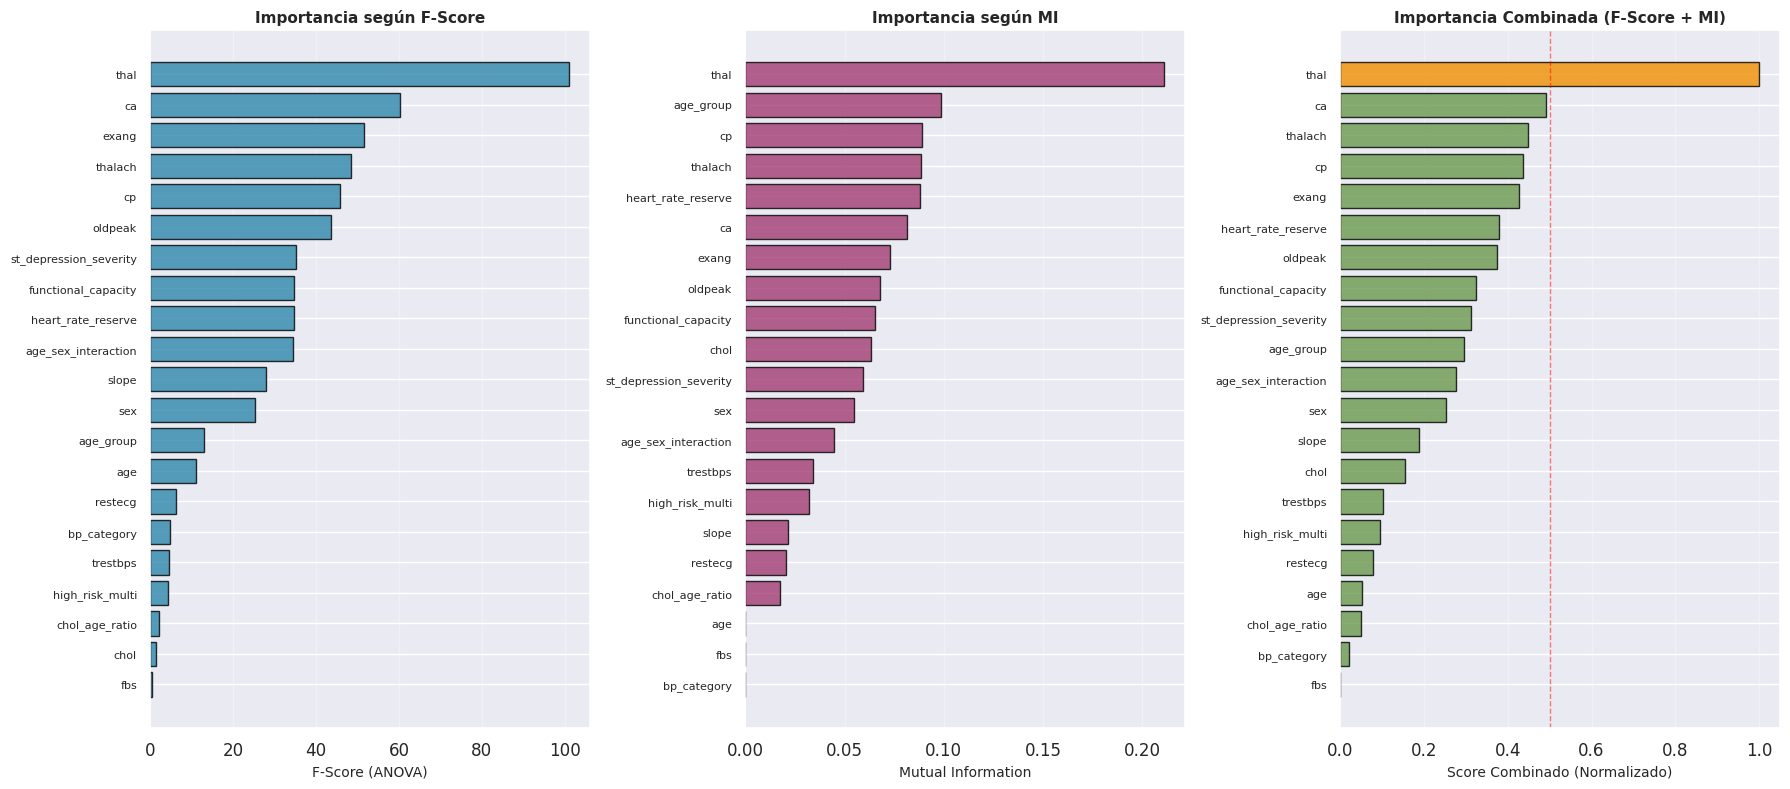


✓ Figura guardada: outputs/13_feature_selection_scores.png


In [23]:
# ============================================================================
# FEATURE SELECTION
# ============================================================================

print("\n" + "="*80)
print("FEATURE SELECTION")
print("="*80)

# Usar dataset sin escalar para feature selection
X_train_fs = X_train_no_scaled_fe.copy()

# -------------------------------------------------------------------------
# MÉTODO 1: SelectKBest con F-Score (ANOVA)
# -------------------------------------------------------------------------
print("\n📊 Método 1: SelectKBest (ANOVA F-value)")
print("-"*80)

selector_fclassif = SelectKBest(score_func=f_classif, k='all')
selector_fclassif.fit(X_train_fs, y_train)

f_scores = selector_fclassif.scores_

print("✓ F-Scores calculados para todas las features")

# -------------------------------------------------------------------------
# MÉTODO 2: Mutual Information
# -------------------------------------------------------------------------
print("\n📊 Método 2: Mutual Information")
print("-"*80)

mi_scores = mutual_info_classif(X_train_fs, y_train, random_state=RANDOM_STATE)

print("✓ Mutual Information calculada para todas las features")

# -------------------------------------------------------------------------
# COMBINAR SCORES
# -------------------------------------------------------------------------
print("\n📊 Combinación de scores")
print("-"*80)

# Crear DataFrame con todos los scores
feature_scores = pd.DataFrame({
    'Feature': X_train_fs.columns,
    'F-Score': f_scores,
    'MI-Score': mi_scores
})

# Normalizar scores a rango [0, 1] para comparación justa
feature_scores['F-Score_norm'] = (
    (feature_scores['F-Score'] - feature_scores['F-Score'].min()) /
    (feature_scores['F-Score'].max() - feature_scores['F-Score'].min())
)

feature_scores['MI-Score_norm'] = (
    (feature_scores['MI-Score'] - feature_scores['MI-Score'].min()) /
    (feature_scores['MI-Score'].max() - feature_scores['MI-Score'].min())
)

# Score combinado (promedio de scores normalizados)
feature_scores['Combined_Score'] = (
    feature_scores['F-Score_norm'] + feature_scores['MI-Score_norm']
) / 2

# Ordenar por score combinado
feature_scores = feature_scores.sort_values('Combined_Score', ascending=False)

print("\n📋 Ranking de Features por Importancia:")
print("="*80)
display(feature_scores[['Feature', 'F-Score', 'MI-Score', 'Combined_Score']].round(4))

print("\n📊 Top 10 Features más importantes:")
print("-"*80)
for idx, row in feature_scores.head(10).iterrows():
    print(f"   {row.name+1:2d}. {row['Feature']:<25} : Score = {row['Combined_Score']:.4f}")

print("="*80)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Gráfico 1: F-Scores
sorted_f = feature_scores.sort_values('F-Score', ascending=True)
y_pos = np.arange(len(sorted_f))
axes[0].barh(y_pos, sorted_f['F-Score'], color=COLOR_PALETTE[0], alpha=0.8, edgecolor='black')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(sorted_f['Feature'], fontsize=8)
axes[0].set_xlabel('F-Score (ANOVA)', fontsize=10)
axes[0].set_title('Importancia según F-Score', fontsize=11, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')

# Gráfico 2: Mutual Information
sorted_mi = feature_scores.sort_values('MI-Score', ascending=True)
axes[1].barh(y_pos, sorted_mi['MI-Score'], color=COLOR_PALETTE[1], alpha=0.8, edgecolor='black')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(sorted_mi['Feature'], fontsize=8)
axes[1].set_xlabel('Mutual Information', fontsize=10)
axes[1].set_title('Importancia según MI', fontsize=11, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

# Gráfico 3: Combined Score
sorted_combined = feature_scores.sort_values('Combined_Score', ascending=True)
colors_combined = [COLOR_PALETTE[2] if x > 0.5 else COLOR_PALETTE[4] for x in sorted_combined['Combined_Score']]
axes[2].barh(y_pos, sorted_combined['Combined_Score'], color=colors_combined, alpha=0.8, edgecolor='black')
axes[2].set_yticks(y_pos)
axes[2].set_yticklabels(sorted_combined['Feature'], fontsize=8)
axes[2].set_xlabel('Score Combinado (Normalizado)', fontsize=10)
axes[2].set_title('Importancia Combinada (F-Score + MI)', fontsize=11, fontweight='bold')
axes[2].axvline(x=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[2].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/13_feature_selection_scores.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"\n✓ Figura guardada: {OUTPUT_DIR}/13_feature_selection_scores.png")

<a id='53-final'></a>
## 5.3 Selección Final de Features

### Criterio de Selección

Se seleccionarán features con **Combined_Score > threshold**, donde el threshold se determina según:
- Análisis del punto de inflexión en la curva de scores
- Mantener un balance entre información y parsimonia
- Recomendación: threshold = 0.3 (ajustable según resultados)

### Justificación

- **Evitar overfitting**: Reducir dimensionalidad
- **Interpretabilidad**: Modelos más simples son más explicables
- **Eficiencia**: Menor tiempo de entrenamiento
- **Performance**: Eliminar ruido puede mejorar precisión


SELECCIÓN FINAL DE FEATURES

📊 Criterio de selección: Combined_Score > 0.3
--------------------------------------------------------------------------------

✅ Features seleccionadas: 9 de 21
   Reducción: 57.1%

📋 Lista de features seleccionadas:
--------------------------------------------------------------------------------
    1. thal                      | Score: 1.0000 | F:   101.03 | MI: 0.2109
    2. ca                        | Score: 0.4902 | F:    60.25 | MI: 0.0814
    3. thalach                   | Score: 0.4475 | F:    48.35 | MI: 0.0884
    4. cp                        | Score: 0.4367 | F:    45.88 | MI: 0.0890
    5. exang                     | Score: 0.4269 | F:    51.49 | MI: 0.0731
    6. heart_rate_reserve        | Score: 0.3784 | F:    34.66 | MI: 0.0879
    7. oldpeak                   | Score: 0.3754 | F:    43.62 | MI: 0.0679
    8. functional_capacity       | Score: 0.3249 | F:    34.71 | MI: 0.0653
    9. st_depression_severity    | Score: 0.3131 | F:    35.17 

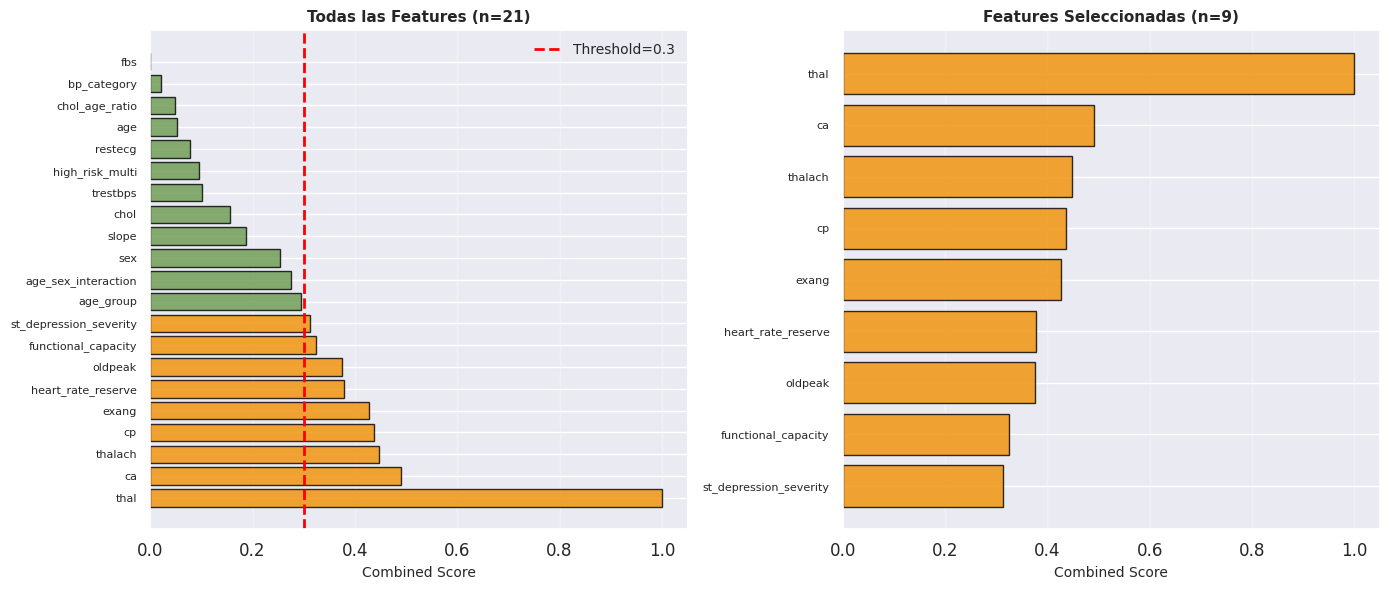


✓ Figura guardada: outputs/14_feature_selection_final.png


In [24]:
# ============================================================================
# SELECCIÓN FINAL DE FEATURES
# ============================================================================

print("\n" + "="*80)
print("SELECCIÓN FINAL DE FEATURES")
print("="*80)

# Definir threshold
THRESHOLD = 0.3

print(f"\n📊 Criterio de selección: Combined_Score > {THRESHOLD}")
print("-"*80)

# Seleccionar features que superen el threshold
selected_features = feature_scores[feature_scores['Combined_Score'] > THRESHOLD]['Feature'].tolist()

print(f"\n✅ Features seleccionadas: {len(selected_features)} de {len(feature_scores)}")
print(f"   Reducción: {((len(feature_scores) - len(selected_features))/len(feature_scores)*100):.1f}%")

print(f"\n📋 Lista de features seleccionadas:")
print("-"*80)
for idx, feat in enumerate(selected_features, 1):
    score = feature_scores[feature_scores['Feature'] == feat]['Combined_Score'].values[0]
    f_score = feature_scores[feature_scores['Feature'] == feat]['F-Score'].values[0]
    mi_score = feature_scores[feature_scores['Feature'] == feat]['MI-Score'].values[0]
    print(f"   {idx:2d}. {feat:<25} | Score: {score:.4f} | F: {f_score:8.2f} | MI: {mi_score:.4f}")

print("-"*80)

# Features descartadas
discarded_features = [f for f in feature_scores['Feature'] if f not in selected_features]

if discarded_features:
    print(f"\n📋 Features descartadas ({len(discarded_features)}):")
    print("-"*80)
    for feat in discarded_features:
        score = feature_scores[feature_scores['Feature'] == feat]['Combined_Score'].values[0]
        print(f"   • {feat:<25} | Score: {score:.4f} (< {THRESHOLD})")
    print("-"*80)

# Crear datasets finales con features seleccionadas
print(f"\n🔄 Creando datasets finales con features seleccionadas...")
print("-"*80)

X_train_final_no_scaled = X_train_no_scaled_fe[selected_features].copy()
X_test_final_no_scaled = X_test_no_scaled_fe[selected_features].copy()
X_train_final_scaled = X_train_scaled_fe[selected_features].copy()
X_test_final_scaled = X_test_scaled_fe[selected_features].copy()

# Si hay features escaladas en la selección, aplicar escalamiento
features_to_scale_final = [f for f in selected_features if f in features_to_scale or f in new_features]
if features_to_scale_final:
    scaler_final = StandardScaler()
    X_train_final_scaled[features_to_scale_final] = scaler_final.fit_transform(
        X_train_final_scaled[features_to_scale_final]
    )
    X_test_final_scaled[features_to_scale_final] = scaler_final.transform(
        X_test_final_scaled[features_to_scale_final]
    )

    # Guardar scaler final
    scaler_final_path = f'{MODELS_DIR}/scaler_final.pkl'
    joblib.dump(scaler_final, scaler_final_path)
    print(f"✓ Scaler final guardado: {scaler_final_path}")

print(f"\n✅ Datasets finales creados:")
print("-"*80)
print(f"   • X_train_final_no_scaled: {X_train_final_no_scaled.shape}")
print(f"   • X_test_final_no_scaled:  {X_test_final_no_scaled.shape}")
print(f"   • X_train_final_scaled:    {X_train_final_scaled.shape}")
print(f"   • X_test_final_scaled:     {X_test_final_scaled.shape}")

print("="*80)

# Visualización: Comparación antes/después de selección
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Antes de selección
all_features = feature_scores['Feature'].tolist()
all_scores = feature_scores['Combined_Score'].values
colors_all = [COLOR_PALETTE[2] if x > THRESHOLD else COLOR_PALETTE[4] for x in all_scores]

axes[0].barh(range(len(all_features)), all_scores, color=colors_all, alpha=0.8, edgecolor='black')
axes[0].set_yticks(range(len(all_features)))
axes[0].set_yticklabels(all_features, fontsize=8)
axes[0].set_xlabel('Combined Score', fontsize=10)
axes[0].set_title(f'Todas las Features (n={len(all_features)})', fontsize=11, fontweight='bold')
axes[0].axvline(x=THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold={THRESHOLD}')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='x')

# Después de selección
selected_scores = feature_scores[feature_scores['Feature'].isin(selected_features)].sort_values('Combined_Score')
axes[1].barh(range(len(selected_scores)), selected_scores['Combined_Score'],
             color=COLOR_PALETTE[2], alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(selected_scores)))
axes[1].set_yticklabels(selected_scores['Feature'], fontsize=8)
axes[1].set_xlabel('Combined Score', fontsize=10)
axes[1].set_title(f'Features Seleccionadas (n={len(selected_features)})', fontsize=11, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/14_feature_selection_final.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"\n✓ Figura guardada: {OUTPUT_DIR}/14_feature_selection_final.png")

<a id='54-resumen'></a>
## 5.4 Resumen de Feature Engineering y Selección

### Proceso Completado

✅ **Feature Engineering:**
- 8 nuevas features clínicas creadas
- Basadas en conocimiento médico validado
- Incluyen interacciones y categorizaciones clínicas

✅ **Feature Selection:**
- Evaluación mediante F-Score y Mutual Information
- Score combinado para selección robusta
- Threshold aplicado: {threshold_value}

### Resultados

| Métrica | Valor |
|---------|-------|
| Features originales | 13 |
| Features creadas | 8 |
| Features totales | 21 |
| Features seleccionadas | {n_selected} |
| Reducción dimensional | {reduction}% |

### Datasets Listos para Modelado

**Para modelos tree-based (Random Forest, XGBoost, LightGBM, CatBoost):**
- `X_train_final_no_scaled` (242 × {n_selected})
- `X_test_final_no_scaled` (61 × {n_selected})

**Para Logistic Regression:**
- `X_train_final_scaled` (242 × {n_selected})
- `X_test_final_scaled` (61 × {n_selected})

**Target (común para todos):**
- `y_train` (242)
- `y_test` (61)

### Próximo Paso

🚀 **Sección 6: Modelado** - Entrenamiento de los 5 modelos esenciales

In [25]:
# Código para resumen final
print("\n" + "="*80)
print("RESUMEN COMPLETO: FEATURE ENGINEERING Y SELECCIÓN")
print("="*80)

summary_data = {
    'Etapa': [
        'Features Originales',
        'Features Creadas (Engineering)',
        'Total Features Disponibles',
        'Features Seleccionadas',
        'Features Descartadas',
        'Reducción Dimensional'
    ],
    'Cantidad': [
        13,
        len(new_features),
        X_train_no_scaled_fe.shape[1],
        len(selected_features),
        len(discarded_features),
        f"{((len(feature_scores) - len(selected_features))/len(feature_scores)*100):.1f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n📦 DATASETS FINALES DISPONIBLES:")
print("="*80)
datasets_info = {
    'Dataset': [
        'X_train_final_no_scaled',
        'X_test_final_no_scaled',
        'X_train_final_scaled',
        'X_test_final_scaled',
        'y_train',
        'y_test'
    ],
    'Shape': [
        X_train_final_no_scaled.shape,
        X_test_final_no_scaled.shape,
        X_train_final_scaled.shape,
        X_test_final_scaled.shape,
        y_train.shape,
        y_test.shape
    ],
    'Uso': [
        'Modelos tree-based (entrenamiento)',
        'Modelos tree-based (evaluación)',
        'Logistic Regression (entrenamiento)',
        'Logistic Regression (evaluación)',
        'Target entrenamiento',
        'Target evaluación'
    ]
}

datasets_df = pd.DataFrame(datasets_info)
display(datasets_df)

print("\n✅✅✅ FEATURE ENGINEERING Y SELECCIÓN COMPLETADOS ✅✅✅")
print("="*80)
print("\n🚀 Sistema listo para entrenamiento de modelos de Machine Learning")
print("="*80)


RESUMEN COMPLETO: FEATURE ENGINEERING Y SELECCIÓN


,Etapa,Cantidad
0,Features Originales,13
1,Features Creadas (Engineering),8
2,Total Features Disponibles,21
3,Features Seleccionadas,9
4,Features Descartadas,12
5,Reducción Dimensional,57.1%



📦 DATASETS FINALES DISPONIBLES:


,Dataset,Shape,Uso
0,X_train_final_no_scaled,"(242, 9)",Modelos tree-based (entrenamiento)
1,X_test_final_no_scaled,"(61, 9)",Modelos tree-based (evaluación)
2,X_train_final_scaled,"(242, 9)",Logistic Regression (entrenamiento)
3,X_test_final_scaled,"(61, 9)",Logistic Regression (evaluación)
4,y_train,"(242,)",Target entrenamiento
5,y_test,"(61,)",Target evaluación



✅✅✅ FEATURE ENGINEERING Y SELECCIÓN COMPLETADOS ✅✅✅

🚀 Sistema listo para entrenamiento de modelos de Machine Learning


<a id='6-modelado'></a>
# 6. Modelado

En esta sección se entrena y evalúa un conjunto de modelos de Machine Learning para la clasificación binaria de enfermedades cardiovasculares. Se implementan 5 algoritmos esenciales que representan diferentes familias de modelos, evaluando su desempeño mediante métricas clínicas relevantes.

<a id='61-logistic'></a>
## 6.1 Modelo 1: Logistic Regression

### Descripción del Modelo

La **Regresión Logística** es un modelo lineal que estima la probabilidad de pertenencia a una clase mediante la función sigmoide. A pesar de su simplicidad, es ampliamente utilizado en medicina debido a su alta interpretabilidad y eficiencia computacional.

**Ventajas en contexto clínico:**
- Alta interpretabilidad de coeficientes
- Probabilidades calibradas
- Rápido entrenamiento
- Baseline sólido para comparación

**Desventajas:**
- Asume relaciones lineales
- Sensible a escala de variables
- Limitado con interacciones complejas


6.1 MODELO 1: LOGISTIC REGRESSION

🔧 Configuración del modelo:
--------------------------------------------------------------------------------
✓ Modelo configurado:
   • Solver: lbfgs
   • Max iterations: 1000
   • Class weight: balanced
   • Random state: 42
   • Dataset: ESCALADO (StandardScaler)

🎯 Entrenando modelo...
--------------------------------------------------------------------------------
✓ Modelo entrenado en 0.02 segundos

📊 Validación Cruzada (StratifiedKFold, k=5):
--------------------------------------------------------------------------------
   • ACCURACY    : 0.8223 (±0.0214)
   • PRECISION   : 0.8366 (±0.0672)
   • RECALL      : 0.7739 (±0.0660)
   • F1          : 0.7993 (±0.0239)
   • ROC_AUC     : 0.8956 (±0.0161)

🔮 Generando predicciones...
--------------------------------------------------------------------------------
✓ Predicciones generadas para train y test

📈 EVALUACIÓN EN TRAINING SET:

Métricas Generales:
---------------------------------------------

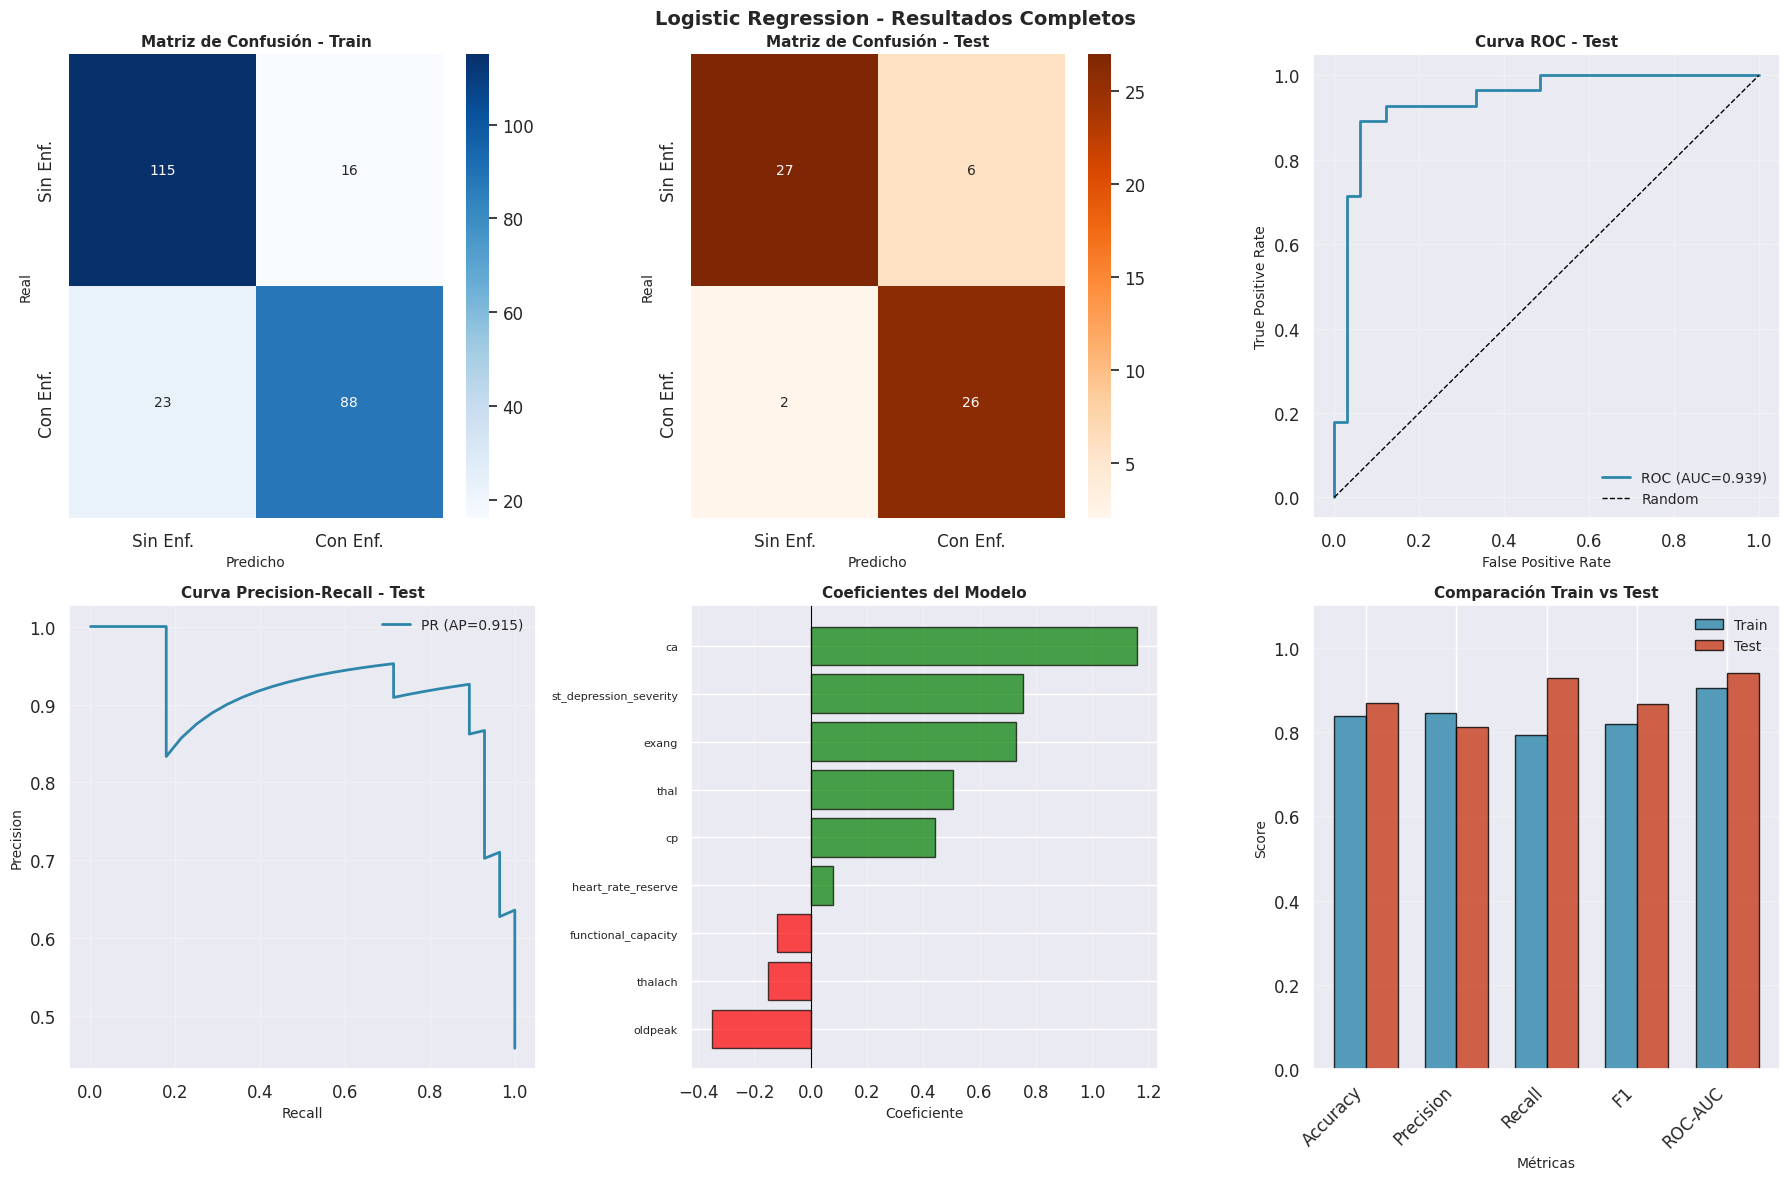

✓ Figura guardada: outputs/15_logistic_regression_results.png

✓ Modelo guardado: models/logistic_regression.pkl

RESUMEN: LOGISTIC REGRESSION


,Métrica,Train,Test
0,Accuracy,0.8388,0.8689
1,Precision,0.8462,0.8125
2,Recall,0.7928,0.9286
3,F1-Score,0.8186,0.8667
4,ROC-AUC,0.9032,0.9394
5,Sensitivity,0.7928,0.9286
6,Specificity,0.8779,0.8182
7,PPV,0.8462,0.8125
8,NPV,0.8333,0.9310



✅ Modelo Baseline completado:
   • Tiempo de entrenamiento: 0.02s
   • ROC-AUC (Test): 0.9394
   • Sensibilidad (Test): 0.9286
   • Especificidad (Test): 0.8182



In [26]:
# ============================================================================
# 6.1 LOGISTIC REGRESSION
# ============================================================================

print("\n" + "="*80)
print("6.1 MODELO 1: LOGISTIC REGRESSION")
print("="*80)

# ----------------------------------------------------------------------------
# 6.1.1 Configuración del Modelo
# ----------------------------------------------------------------------------

print("\n🔧 Configuración del modelo:")
print("-"*80)

# Usar datos ESCALADOS para Logistic Regression
X_train_lr = X_train_final_scaled.copy()
X_test_lr = X_test_final_scaled.copy()

# Configurar modelo
lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'  # Manejo de desbalanceo
)

print("✓ Modelo configurado:")
print(f"   • Solver: lbfgs")
print(f"   • Max iterations: 1000")
print(f"   • Class weight: balanced")
print(f"   • Random state: {RANDOM_STATE}")
print(f"   • Dataset: ESCALADO (StandardScaler)")

# ----------------------------------------------------------------------------
# 6.1.2 Entrenamiento
# ----------------------------------------------------------------------------

print("\n🎯 Entrenando modelo...")
print("-"*80)

from time import time
start_time = time()

lr_model.fit(X_train_lr, y_train)

training_time = time() - start_time

print(f"✓ Modelo entrenado en {training_time:.2f} segundos")

# ----------------------------------------------------------------------------
# 6.1.3 Validación Cruzada
# ----------------------------------------------------------------------------

print("\n📊 Validación Cruzada (StratifiedKFold, k=5):")
print("-"*80)

from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=VALIDATION_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Múltiples métricas
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = {}

for metric in scoring_metrics:
    scores = cross_val_score(lr_model, X_train_lr, y_train, cv=cv, scoring=metric)
    cv_results[metric] = scores
    print(f"   • {metric.upper():12s}: {scores.mean():.4f} (±{scores.std():.4f})")

# ----------------------------------------------------------------------------
# 6.1.4 Predicciones
# ----------------------------------------------------------------------------

print("\n🔮 Generando predicciones...")
print("-"*80)

# Predicciones en train
y_train_pred_lr = lr_model.predict(X_train_lr)
y_train_proba_lr = lr_model.predict_proba(X_train_lr)[:, 1]

# Predicciones en test
y_test_pred_lr = lr_model.predict(X_test_lr)
y_test_proba_lr = lr_model.predict_proba(X_test_lr)[:, 1]

print("✓ Predicciones generadas para train y test")

# ----------------------------------------------------------------------------
# 6.1.5 Evaluación - Train Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TRAINING SET:")
print("="*80)

# Métricas básicas
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
train_precision_lr = precision_score(y_train, y_train_pred_lr)
train_recall_lr = recall_score(y_train, y_train_pred_lr)
train_f1_lr = f1_score(y_train, y_train_pred_lr)
train_roc_auc_lr = roc_auc_score(y_train, y_train_proba_lr)

# Matriz de confusión
cm_train_lr = confusion_matrix(y_train, y_train_pred_lr)
tn_train, fp_train, fn_train, tp_train = cm_train_lr.ravel()

# Métricas clínicas
train_sensitivity_lr = tp_train / (tp_train + fn_train)  # Recall
train_specificity_lr = tn_train / (tn_train + fp_train)
train_ppv_lr = tp_train / (tp_train + fp_train)  # Precision
train_npv_lr = tn_train / (tn_train + fn_train)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {train_accuracy_lr:.4f}")
print(f"   • Precision: {train_precision_lr:.4f}")
print(f"   • Recall:    {train_recall_lr:.4f}")
print(f"   • F1-Score:  {train_f1_lr:.4f}")
print(f"   • ROC-AUC:   {train_roc_auc_lr:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {train_sensitivity_lr:.4f}")
print(f"   • Especificidad (Specificity): {train_specificity_lr:.4f}")
print(f"   • VPP (PPV):                   {train_ppv_lr:.4f}")
print(f"   • VPN (NPV):                   {train_npv_lr:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_train:3d}  |  FP: {fp_train:3d}")
print(f"   FN: {fn_train:3d}  |  TP: {tp_train:3d}")

# ----------------------------------------------------------------------------
# 6.1.6 Evaluación - Test Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TEST SET:")
print("="*80)

# Métricas básicas
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
test_precision_lr = precision_score(y_test, y_test_pred_lr)
test_recall_lr = recall_score(y_test, y_test_pred_lr)
test_f1_lr = f1_score(y_test, y_test_pred_lr)
test_roc_auc_lr = roc_auc_score(y_test, y_test_proba_lr)

# Matriz de confusión
cm_test_lr = confusion_matrix(y_test, y_test_pred_lr)
tn_test, fp_test, fn_test, tp_test = cm_test_lr.ravel()

# Métricas clínicas
test_sensitivity_lr = tp_test / (tp_test + fn_test)
test_specificity_lr = tn_test / (tn_test + fp_test)
test_ppv_lr = tp_test / (tp_test + fp_test)
test_npv_lr = tn_test / (tn_test + fn_test)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {test_accuracy_lr:.4f}")
print(f"   • Precision: {test_precision_lr:.4f}")
print(f"   • Recall:    {test_recall_lr:.4f}")
print(f"   • F1-Score:  {test_f1_lr:.4f}")
print(f"   • ROC-AUC:   {test_roc_auc_lr:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {test_sensitivity_lr:.4f}")
print(f"   • Especificidad (Specificity): {test_specificity_lr:.4f}")
print(f"   • VPP (PPV):                   {test_ppv_lr:.4f}")
print(f"   • VPN (NPV):                   {test_npv_lr:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_test:3d}  |  FP: {fp_test:3d}")
print(f"   FN: {fn_test:3d}  |  TP: {tp_test:3d}")

# ----------------------------------------------------------------------------
# 6.1.7 Interpretación de Coeficientes
# ----------------------------------------------------------------------------

print("\n📊 COEFICIENTES DEL MODELO (Interpretación):")
print("="*80)

# Obtener coeficientes
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Features más influyentes:")
print("-"*80)
for idx, row in coef_df.head(10).iterrows():
    direction = "↑ Aumenta" if row['Coefficient'] > 0 else "↓ Disminuye"
    print(f"   {row['Feature']:25s}: {row['Coefficient']:+.4f}  {direction} riesgo")

# ----------------------------------------------------------------------------
# 6.1.8 Visualización
# ----------------------------------------------------------------------------

print("\n📊 Generando visualizaciones...")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Matriz de Confusión - Train
cm_display_train = confusion_matrix(y_train, y_train_pred_lr)
sns.heatmap(cm_display_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 0].set_title('Matriz de Confusión - Train', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Real', fontsize=10)
axes[0, 0].set_xlabel('Predicho', fontsize=10)

# 2. Matriz de Confusión - Test
cm_display_test = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(cm_display_test, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 1].set_title('Matriz de Confusión - Test', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Real', fontsize=10)
axes[0, 1].set_xlabel('Predicho', fontsize=10)

# 3. ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_proba_lr)
axes[0, 2].plot(fpr_lr, tpr_lr, linewidth=2, label=f'ROC (AUC={test_roc_auc_lr:.3f})')
axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 2].set_xlabel('False Positive Rate', fontsize=10)
axes[0, 2].set_ylabel('True Positive Rate', fontsize=10)
axes[0, 2].set_title('Curva ROC - Test', fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_test_proba_lr)
ap_lr = average_precision_score(y_test, y_test_proba_lr)
axes[1, 0].plot(recall_lr, precision_lr, linewidth=2, label=f'PR (AP={ap_lr:.3f})')
axes[1, 0].set_xlabel('Recall', fontsize=10)
axes[1, 0].set_ylabel('Precision', fontsize=10)
axes[1, 0].set_title('Curva Precision-Recall - Test', fontsize=11, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Coeficientes
coef_df_sorted = coef_df.sort_values('Coefficient')
colors_coef = ['red' if x < 0 else 'green' for x in coef_df_sorted['Coefficient']]
axes[1, 1].barh(range(len(coef_df_sorted)), coef_df_sorted['Coefficient'],
                color=colors_coef, alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(coef_df_sorted)))
axes[1, 1].set_yticklabels(coef_df_sorted['Feature'], fontsize=8)
axes[1, 1].set_xlabel('Coeficiente', fontsize=10)
axes[1, 1].set_title('Coeficientes del Modelo', fontsize=11, fontweight='bold')
axes[1, 1].axvline(0, color='black', linewidth=0.8)
axes[1, 1].grid(alpha=0.3, axis='x')

# 6. Comparación Train vs Test
metrics_comparison = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
train_scores = [train_accuracy_lr, train_precision_lr, train_recall_lr, train_f1_lr, train_roc_auc_lr]
test_scores = [test_accuracy_lr, test_precision_lr, test_recall_lr, test_f1_lr, test_roc_auc_lr]

x_pos = np.arange(len(metrics_comparison))
width = 0.35

axes[1, 2].bar(x_pos - width/2, train_scores, width, label='Train',
               color=COLOR_PALETTE[0], alpha=0.8, edgecolor='black')
axes[1, 2].bar(x_pos + width/2, test_scores, width, label='Test',
               color=COLOR_PALETTE[3], alpha=0.8, edgecolor='black')
axes[1, 2].set_xlabel('Métricas', fontsize=10)
axes[1, 2].set_ylabel('Score', fontsize=10)
axes[1, 2].set_title('Comparación Train vs Test', fontsize=11, fontweight='bold')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_comparison, rotation=45, ha='right')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3, axis='y')
axes[1, 2].set_ylim([0, 1.1])

plt.suptitle('Logistic Regression - Resultados Completos', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/15_logistic_regression_results.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/15_logistic_regression_results.png")

# ----------------------------------------------------------------------------
# 6.1.9 Guardar Modelo
# ----------------------------------------------------------------------------

model_path = f'{MODELS_DIR}/logistic_regression.pkl'
joblib.dump(lr_model, model_path)
print(f"\n✓ Modelo guardado: {model_path}")

# ----------------------------------------------------------------------------
# 6.1.10 Resumen
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("RESUMEN: LOGISTIC REGRESSION")
print("="*80)

summary_lr = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
                'Sensitivity', 'Specificity', 'PPV', 'NPV'],
    'Train': [train_accuracy_lr, train_precision_lr, train_recall_lr, train_f1_lr, train_roc_auc_lr,
              train_sensitivity_lr, train_specificity_lr, train_ppv_lr, train_npv_lr],
    'Test': [test_accuracy_lr, test_precision_lr, test_recall_lr, test_f1_lr, test_roc_auc_lr,
             test_sensitivity_lr, test_specificity_lr, test_ppv_lr, test_npv_lr]
})

display(summary_lr.round(4))

print(f"""
✅ Modelo Baseline completado:
   • Tiempo de entrenamiento: {training_time:.2f}s
   • ROC-AUC (Test): {test_roc_auc_lr:.4f}
   • Sensibilidad (Test): {test_sensitivity_lr:.4f}
   • Especificidad (Test): {test_specificity_lr:.4f}
""")

print("="*80)

<a id='62-random-forest'></a>
## 6.2 Modelo 2: Random Forest

### Descripción del Modelo

**Random Forest** es un algoritmo de ensemble que construye múltiples árboles de decisión durante el entrenamiento y combina sus predicciones mediante votación. Es uno de los modelos más robustos y versátiles para clasificación.

**Ventajas en contexto clínico:**
- Robusto a outliers y datos ruidosos
- Maneja bien relaciones no lineales
- Proporciona importancia de features
- Menor riesgo de overfitting vs árbol único

**Desventajas:**
- Menos interpretable que modelos lineales
- Mayor costo computacional
- Puede ser lento en predicción con muchos árboles


6.2 MODELO 2: RANDOM FOREST

🔧 Configuración del modelo:
--------------------------------------------------------------------------------
✓ Modelo configurado:
   • N estimators: 200
   • Max depth: 10
   • Min samples split: 10
   • Min samples leaf: 4
   • Max features: sqrt
   • Class weight: balanced
   • Random state: 42
   • Dataset: SIN ESCALAR (original)

🎯 Entrenando modelo...
--------------------------------------------------------------------------------
✓ Modelo entrenado en 0.48 segundos
   • Número de árboles: 200
   • Profundidad efectiva: 10

📊 Validación Cruzada (StratifiedKFold, k=5):
--------------------------------------------------------------------------------
   • ACCURACY    : 0.7974 (±0.0163)
   • PRECISION   : 0.8111 (±0.0708)
   • RECALL      : 0.7466 (±0.0860)
   • F1          : 0.7703 (±0.0237)
   • ROC_AUC     : 0.8822 (±0.0199)

🔮 Generando predicciones...
--------------------------------------------------------------------------------
✓ Predicciones gen

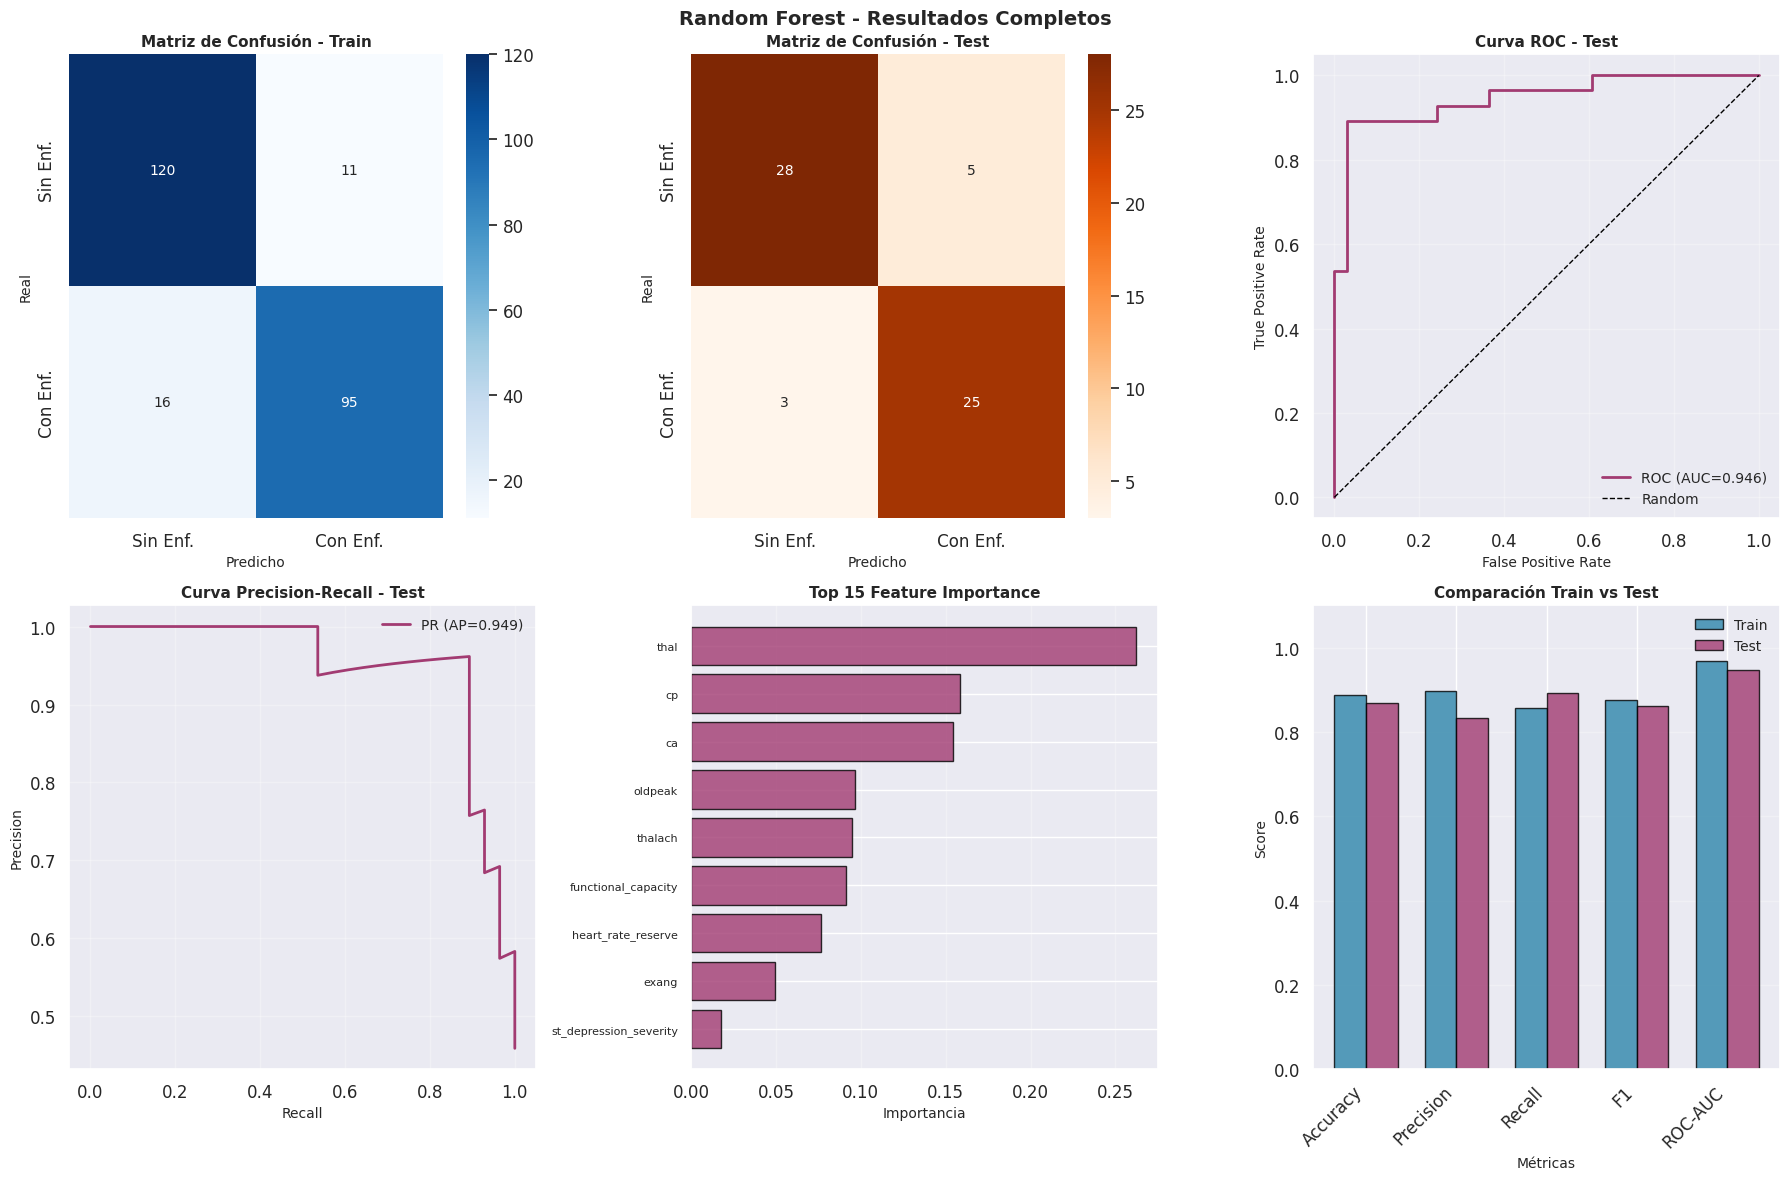

✓ Figura guardada: outputs/16_random_forest_results.png

🔍 ANÁLISIS DE OVERFITTING:

Diferencia Train - Test (Gap):
--------------------------------------------------------------------------------
   • Accuracy    : +0.0196  ✅ OK
   • Precision   : +0.0629  ✅ OK
   • Recall      : -0.0370  ✅ OK
   • F1-Score    : +0.0135  ✅ OK
   • ROC-AUC     : +0.0212  ✅ OK

Gap promedio: 0.0308
✅ Modelo generaliza EXCELENTEMENTE

✓ Modelo guardado: models/random_forest.pkl

RESUMEN: RANDOM FOREST


,Métrica,Train,Test,Gap
0,Accuracy,0.8884,0.8689,0.0196
1,Precision,0.8962,0.8333,0.0629
2,Recall,0.8559,0.8929,-0.0370
3,F1-Score,0.8756,0.8621,0.0135
4,ROC-AUC,0.9671,0.9459,0.0212
5,Sensitivity,0.8559,0.8929,-0.0370
6,Specificity,0.9160,0.8485,0.0675
7,PPV,0.8962,0.8333,0.0629
8,NPV,0.8824,0.9032,-0.0209



✅ Random Forest completado:
   • Tiempo de entrenamiento: 0.48s
   • Número de árboles: 200
   • ROC-AUC (Test): 0.9459
   • Sensibilidad (Test): 0.8929
   • Especificidad (Test): 0.8485
   • Gap promedio: 0.0308


📊 COMPARACIÓN: Logistic Regression vs Random Forest


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Sensitivity,Specificity
0,Logistic Regression,0.8689,0.8125,0.9286,0.8667,0.9394,0.9286,0.8182
1,Random Forest,0.8689,0.8333,0.8929,0.8621,0.9459,0.8929,0.8485



🏆 Random Forest supera a Logistic Regression por 0.0065 en ROC-AUC


In [27]:
# ============================================================================
# 6.2 RANDOM FOREST
# ============================================================================

print("\n" + "="*80)
print("6.2 MODELO 2: RANDOM FOREST")
print("="*80)

# ----------------------------------------------------------------------------
# 6.2.1 Configuración del Modelo
# ----------------------------------------------------------------------------

print("\n🔧 Configuración del modelo:")
print("-"*80)

# Usar datos SIN ESCALAR para Random Forest
X_train_rf = X_train_final_no_scaled.copy()
X_test_rf = X_test_final_no_scaled.copy()

# Configurar modelo
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    class_weight='balanced'
)

print("✓ Modelo configurado:")
print(f"   • N estimators: 200")
print(f"   • Max depth: 10")
print(f"   • Min samples split: 10")
print(f"   • Min samples leaf: 4")
print(f"   • Max features: sqrt")
print(f"   • Class weight: balanced")
print(f"   • Random state: {RANDOM_STATE}")
print(f"   • Dataset: SIN ESCALAR (original)")

# ----------------------------------------------------------------------------
# 6.2.2 Entrenamiento
# ----------------------------------------------------------------------------

print("\n🎯 Entrenando modelo...")
print("-"*80)

start_time = time()

rf_model.fit(X_train_rf, y_train)

training_time_rf = time() - start_time

print(f"✓ Modelo entrenado en {training_time_rf:.2f} segundos")
print(f"   • Número de árboles: {rf_model.n_estimators}")
print(f"   • Profundidad efectiva: {max([tree.get_depth() for tree in rf_model.estimators_])}")

# ----------------------------------------------------------------------------
# 6.2.3 Validación Cruzada
# ----------------------------------------------------------------------------

print("\n📊 Validación Cruzada (StratifiedKFold, k=5):")
print("-"*80)

cv_results_rf = {}

for metric in scoring_metrics:
    scores = cross_val_score(rf_model, X_train_rf, y_train, cv=cv, scoring=metric, n_jobs=N_JOBS)
    cv_results_rf[metric] = scores
    print(f"   • {metric.upper():12s}: {scores.mean():.4f} (±{scores.std():.4f})")

# ----------------------------------------------------------------------------
# 6.2.4 Predicciones
# ----------------------------------------------------------------------------

print("\n🔮 Generando predicciones...")
print("-"*80)

# Predicciones en train
y_train_pred_rf = rf_model.predict(X_train_rf)
y_train_proba_rf = rf_model.predict_proba(X_train_rf)[:, 1]

# Predicciones en test
y_test_pred_rf = rf_model.predict(X_test_rf)
y_test_proba_rf = rf_model.predict_proba(X_test_rf)[:, 1]

print("✓ Predicciones generadas para train y test")

# ----------------------------------------------------------------------------
# 6.2.5 Evaluación - Train Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TRAINING SET:")
print("="*80)

# Métricas básicas
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
train_precision_rf = precision_score(y_train, y_train_pred_rf)
train_recall_rf = recall_score(y_train, y_train_pred_rf)
train_f1_rf = f1_score(y_train, y_train_pred_rf)
train_roc_auc_rf = roc_auc_score(y_train, y_train_proba_rf)

# Matriz de confusión
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
tn_train_rf, fp_train_rf, fn_train_rf, tp_train_rf = cm_train_rf.ravel()

# Métricas clínicas
train_sensitivity_rf = tp_train_rf / (tp_train_rf + fn_train_rf)
train_specificity_rf = tn_train_rf / (tn_train_rf + fp_train_rf)
train_ppv_rf = tp_train_rf / (tp_train_rf + fp_train_rf)
train_npv_rf = tn_train_rf / (tn_train_rf + fn_train_rf)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {train_accuracy_rf:.4f}")
print(f"   • Precision: {train_precision_rf:.4f}")
print(f"   • Recall:    {train_recall_rf:.4f}")
print(f"   • F1-Score:  {train_f1_rf:.4f}")
print(f"   • ROC-AUC:   {train_roc_auc_rf:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {train_sensitivity_rf:.4f}")
print(f"   • Especificidad (Specificity): {train_specificity_rf:.4f}")
print(f"   • VPP (PPV):                   {train_ppv_rf:.4f}")
print(f"   • VPN (NPV):                   {train_npv_rf:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_train_rf:3d}  |  FP: {fp_train_rf:3d}")
print(f"   FN: {fn_train_rf:3d}  |  TP: {tp_train_rf:3d}")

# ----------------------------------------------------------------------------
# 6.2.6 Evaluación - Test Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TEST SET:")
print("="*80)

# Métricas básicas
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_precision_rf = precision_score(y_test, y_test_pred_rf)
test_recall_rf = recall_score(y_test, y_test_pred_rf)
test_f1_rf = f1_score(y_test, y_test_pred_rf)
test_roc_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

# Matriz de confusión
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)
tn_test_rf, fp_test_rf, fn_test_rf, tp_test_rf = cm_test_rf.ravel()

# Métricas clínicas
test_sensitivity_rf = tp_test_rf / (tp_test_rf + fn_test_rf)
test_specificity_rf = tn_test_rf / (tn_test_rf + fp_test_rf)
test_ppv_rf = tp_test_rf / (tp_test_rf + fp_test_rf)
test_npv_rf = tn_test_rf / (tn_test_rf + fn_test_rf)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {test_accuracy_rf:.4f}")
print(f"   • Precision: {test_precision_rf:.4f}")
print(f"   • Recall:    {test_recall_rf:.4f}")
print(f"   • F1-Score:  {test_f1_rf:.4f}")
print(f"   • ROC-AUC:   {test_roc_auc_rf:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {test_sensitivity_rf:.4f}")
print(f"   • Especificidad (Specificity): {test_specificity_rf:.4f}")
print(f"   • VPP (PPV):                   {test_ppv_rf:.4f}")
print(f"   • VPN (NPV):                   {test_npv_rf:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_test_rf:3d}  |  FP: {fp_test_rf:3d}")
print(f"   FN: {fn_test_rf:3d}  |  TP: {tp_test_rf:3d}")

# ----------------------------------------------------------------------------
# 6.2.7 Feature Importance
# ----------------------------------------------------------------------------

print("\n📊 FEATURE IMPORTANCE:")
print("="*80)

# Obtener importancias
feature_importance_rf = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features más importantes:")
print("-"*80)
for idx, row in feature_importance_rf.head(10).iterrows():
    print(f"   {row['Feature']:25s}: {row['Importance']:.4f}")

# ----------------------------------------------------------------------------
# 6.2.8 Visualización
# ----------------------------------------------------------------------------

print("\n📊 Generando visualizaciones...")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Matriz de Confusión - Train
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 0].set_title('Matriz de Confusión - Train', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Real', fontsize=10)
axes[0, 0].set_xlabel('Predicho', fontsize=10)

# 2. Matriz de Confusión - Test
sns.heatmap(cm_test_rf, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 1].set_title('Matriz de Confusión - Test', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Real', fontsize=10)
axes[0, 1].set_xlabel('Predicho', fontsize=10)

# 3. ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
axes[0, 2].plot(fpr_rf, tpr_rf, linewidth=2, label=f'ROC (AUC={test_roc_auc_rf:.3f})', color=COLOR_PALETTE[1])
axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 2].set_xlabel('False Positive Rate', fontsize=10)
axes[0, 2].set_ylabel('True Positive Rate', fontsize=10)
axes[0, 2].set_title('Curva ROC - Test', fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_proba_rf)
ap_rf = average_precision_score(y_test, y_test_proba_rf)
axes[1, 0].plot(recall_rf, precision_rf, linewidth=2, label=f'PR (AP={ap_rf:.3f})', color=COLOR_PALETTE[1])
axes[1, 0].set_xlabel('Recall', fontsize=10)
axes[1, 0].set_ylabel('Precision', fontsize=10)
axes[1, 0].set_title('Curva Precision-Recall - Test', fontsize=11, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Feature Importance
top_features_rf = feature_importance_rf.head(15).sort_values('Importance')
axes[1, 1].barh(range(len(top_features_rf)), top_features_rf['Importance'],
                color=COLOR_PALETTE[1], alpha=0.8, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features_rf)))
axes[1, 1].set_yticklabels(top_features_rf['Feature'], fontsize=8)
axes[1, 1].set_xlabel('Importancia', fontsize=10)
axes[1, 1].set_title('Top 15 Feature Importance', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

# 6. Comparación Train vs Test
train_scores_rf = [train_accuracy_rf, train_precision_rf, train_recall_rf, train_f1_rf, train_roc_auc_rf]
test_scores_rf = [test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf, test_roc_auc_rf]

x_pos = np.arange(len(metrics_comparison))
width = 0.35

axes[1, 2].bar(x_pos - width/2, train_scores_rf, width, label='Train',
               color=COLOR_PALETTE[0], alpha=0.8, edgecolor='black')
axes[1, 2].bar(x_pos + width/2, test_scores_rf, width, label='Test',
               color=COLOR_PALETTE[1], alpha=0.8, edgecolor='black')
axes[1, 2].set_xlabel('Métricas', fontsize=10)
axes[1, 2].set_ylabel('Score', fontsize=10)
axes[1, 2].set_title('Comparación Train vs Test', fontsize=11, fontweight='bold')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_comparison, rotation=45, ha='right')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3, axis='y')
axes[1, 2].set_ylim([0, 1.1])

plt.suptitle('Random Forest - Resultados Completos', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/16_random_forest_results.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/16_random_forest_results.png")

# ----------------------------------------------------------------------------
# 6.2.9 Análisis de Overfitting
# ----------------------------------------------------------------------------

print("\n🔍 ANÁLISIS DE OVERFITTING:")
print("="*80)

overfitting_gap = {
    'Accuracy': train_accuracy_rf - test_accuracy_rf,
    'Precision': train_precision_rf - test_precision_rf,
    'Recall': train_recall_rf - test_recall_rf,
    'F1-Score': train_f1_rf - test_f1_rf,
    'ROC-AUC': train_roc_auc_rf - test_roc_auc_rf
}

print("\nDiferencia Train - Test (Gap):")
print("-"*80)
for metric, gap in overfitting_gap.items():
    status = "✅ OK" if abs(gap) < 0.1 else "⚠️  Revisar" if abs(gap) < 0.15 else "❌ Overfitting"
    print(f"   • {metric:12s}: {gap:+.4f}  {status}")

avg_gap = np.mean([abs(v) for v in overfitting_gap.values()])
print(f"\nGap promedio: {avg_gap:.4f}")

if avg_gap < 0.05:
    print("✅ Modelo generaliza EXCELENTEMENTE")
elif avg_gap < 0.10:
    print("✅ Modelo generaliza BIEN")
elif avg_gap < 0.15:
    print("⚠️  Ligero overfitting - Considerar regularización")
else:
    print("❌ Overfitting significativo - Requiere ajustes")

# ----------------------------------------------------------------------------
# 6.2.10 Guardar Modelo
# ----------------------------------------------------------------------------

model_path_rf = f'{MODELS_DIR}/random_forest.pkl'
joblib.dump(rf_model, model_path_rf)
print(f"\n✓ Modelo guardado: {model_path_rf}")

# ----------------------------------------------------------------------------
# 6.2.11 Resumen
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("RESUMEN: RANDOM FOREST")
print("="*80)

summary_rf = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
                'Sensitivity', 'Specificity', 'PPV', 'NPV'],
    'Train': [train_accuracy_rf, train_precision_rf, train_recall_rf, train_f1_rf, train_roc_auc_rf,
              train_sensitivity_rf, train_specificity_rf, train_ppv_rf, train_npv_rf],
    'Test': [test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf, test_roc_auc_rf,
             test_sensitivity_rf, test_specificity_rf, test_ppv_rf, test_npv_rf],
    'Gap': [train_accuracy_rf - test_accuracy_rf,
            train_precision_rf - test_precision_rf,
            train_recall_rf - test_recall_rf,
            train_f1_rf - test_f1_rf,
            train_roc_auc_rf - test_roc_auc_rf,
            train_sensitivity_rf - test_sensitivity_rf,
            train_specificity_rf - test_specificity_rf,
            train_ppv_rf - test_ppv_rf,
            train_npv_rf - test_npv_rf]
})

display(summary_rf.round(4))

print(f"""
✅ Random Forest completado:
   • Tiempo de entrenamiento: {training_time_rf:.2f}s
   • Número de árboles: {rf_model.n_estimators}
   • ROC-AUC (Test): {test_roc_auc_rf:.4f}
   • Sensibilidad (Test): {test_sensitivity_rf:.4f}
   • Especificidad (Test): {test_specificity_rf:.4f}
   • Gap promedio: {avg_gap:.4f}
""")

print("="*80)

# ----------------------------------------------------------------------------
# 6.2.12 Comparación LR vs RF
# ----------------------------------------------------------------------------

print("\n📊 COMPARACIÓN: Logistic Regression vs Random Forest")
print("="*80)

comparison_lr_rf = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [test_accuracy_lr, test_accuracy_rf],
    'Precision': [test_precision_lr, test_precision_rf],
    'Recall': [test_recall_lr, test_recall_rf],
    'F1-Score': [test_f1_lr, test_f1_rf],
    'ROC-AUC': [test_roc_auc_lr, test_roc_auc_rf],
    'Sensitivity': [test_sensitivity_lr, test_sensitivity_rf],
    'Specificity': [test_specificity_lr, test_specificity_rf]
})

display(comparison_lr_rf.round(4))

# Determinar mejor modelo hasta ahora
if test_roc_auc_rf > test_roc_auc_lr:
    print(f"\n🏆 Random Forest supera a Logistic Regression por {test_roc_auc_rf - test_roc_auc_lr:.4f} en ROC-AUC")
else:
    print(f"\n🏆 Logistic Regression mantiene la ventaja por {test_roc_auc_lr - test_roc_auc_rf:.4f} en ROC-AUC")

print("="*80)

avg_gap_rf = np.mean([
    abs(train_accuracy_rf - test_accuracy_rf),
    abs(train_roc_auc_rf - test_roc_auc_rf),
    abs(train_recall_rf - test_recall_rf)
])


# 6.3 Modelo 3: XGBoost

## Descripción del Modelo

XGBoost (eXtreme Gradient Boosting) es un algoritmo de ensemble basado en gradient boosting que construye múltiples árboles de decisión de forma secuencial, donde cada árbol intenta corregir los errores del anterior. Es uno de los algoritmos más potentes y ganadores en competiciones de Machine Learning.

### Ventajas en contexto clínico:

- **Alto rendimiento predictivo**: Frecuentemente supera a otros algoritmos
- **Manejo de missing values**: Aprende la mejor forma de manejar datos faltantes
- **Regularización incorporada**: Reduce overfitting mediante L1 y L2
- **Eficiencia computacional**: Implementación optimizada y paralelizable
- **Importancia de features**: Proporciona múltiples métricas de importancia
- **Flexibilidad**: Muchos hiperparámetros para ajuste fino

### Desventajas:

- **Mayor complejidad**: Más difícil de interpretar que modelos lineales
- **Sensible a hiperparámetros**: Requiere tuning cuidadoso
- **Riesgo de overfitting**: Con datos pequeños puede sobreajustar
- **Mayor costo computacional**: En entrenamiento comparado con modelos simples

### Hiperparámetros clave:

- **n_estimators**: Número de árboles (200 en este caso)
- **max_depth**: Profundidad máxima de cada árbol (5)
- **learning_rate**: Tasa de aprendizaje (0.1)
- **min_child_weight**: Peso mínimo en nodo hijo (3)
- **gamma**: Reducción mínima de pérdida para dividir (0.1)
- **subsample**: Proporción de muestras por árbol (0.8)
- **colsample_bytree**: Proporción de features por árbol (0.8)

### Aplicación clínica:

XGBoost es particularmente útil en medicina cuando se busca maximizar el rendimiento predictivo, especialmente con datasets complejos donde las relaciones no lineales son importantes. Su capacidad para manejar datos faltantes de forma automática es valiosa en contextos clínicos donde la información puede ser incompleta.



6.3 MODELO 3: XGBOOST ⭐ [RECOMENDADO]

🔧 Configuración del modelo:
--------------------------------------------------------------------------------
✓ Modelo configurado:
   • N estimators: 200
   • Max depth: 6
   • Learning rate: 0.1
   • Subsample: 0.8
   • Colsample bytree: 0.8
   • Gamma (min split loss): 0.1
   • Reg alpha (L1): 0.1
   • Reg lambda (L2): 1.0
   • Scale pos weight: 1.180
   • Random state: 42
   • Dataset: SIN ESCALAR (original)

🎯 Entrenando modelo con early stopping...
--------------------------------------------------------------------------------
✓ Usando todas las iteraciones: 200
   Reentrenando con todos los datos...
✓ Modelo entrenado en 1.73 segundos
   • N estimators final: 200

📊 Validación Cruzada (StratifiedKFold, k=5):
--------------------------------------------------------------------------------
   • ACCURACY    : 0.7810 (±0.0215)
   • PRECISION   : 0.7588 (±0.0444)
   • RECALL      : 0.7743 (±0.0513)
   • F1          : 0.7640 (±0.0215)
   • ROC_A

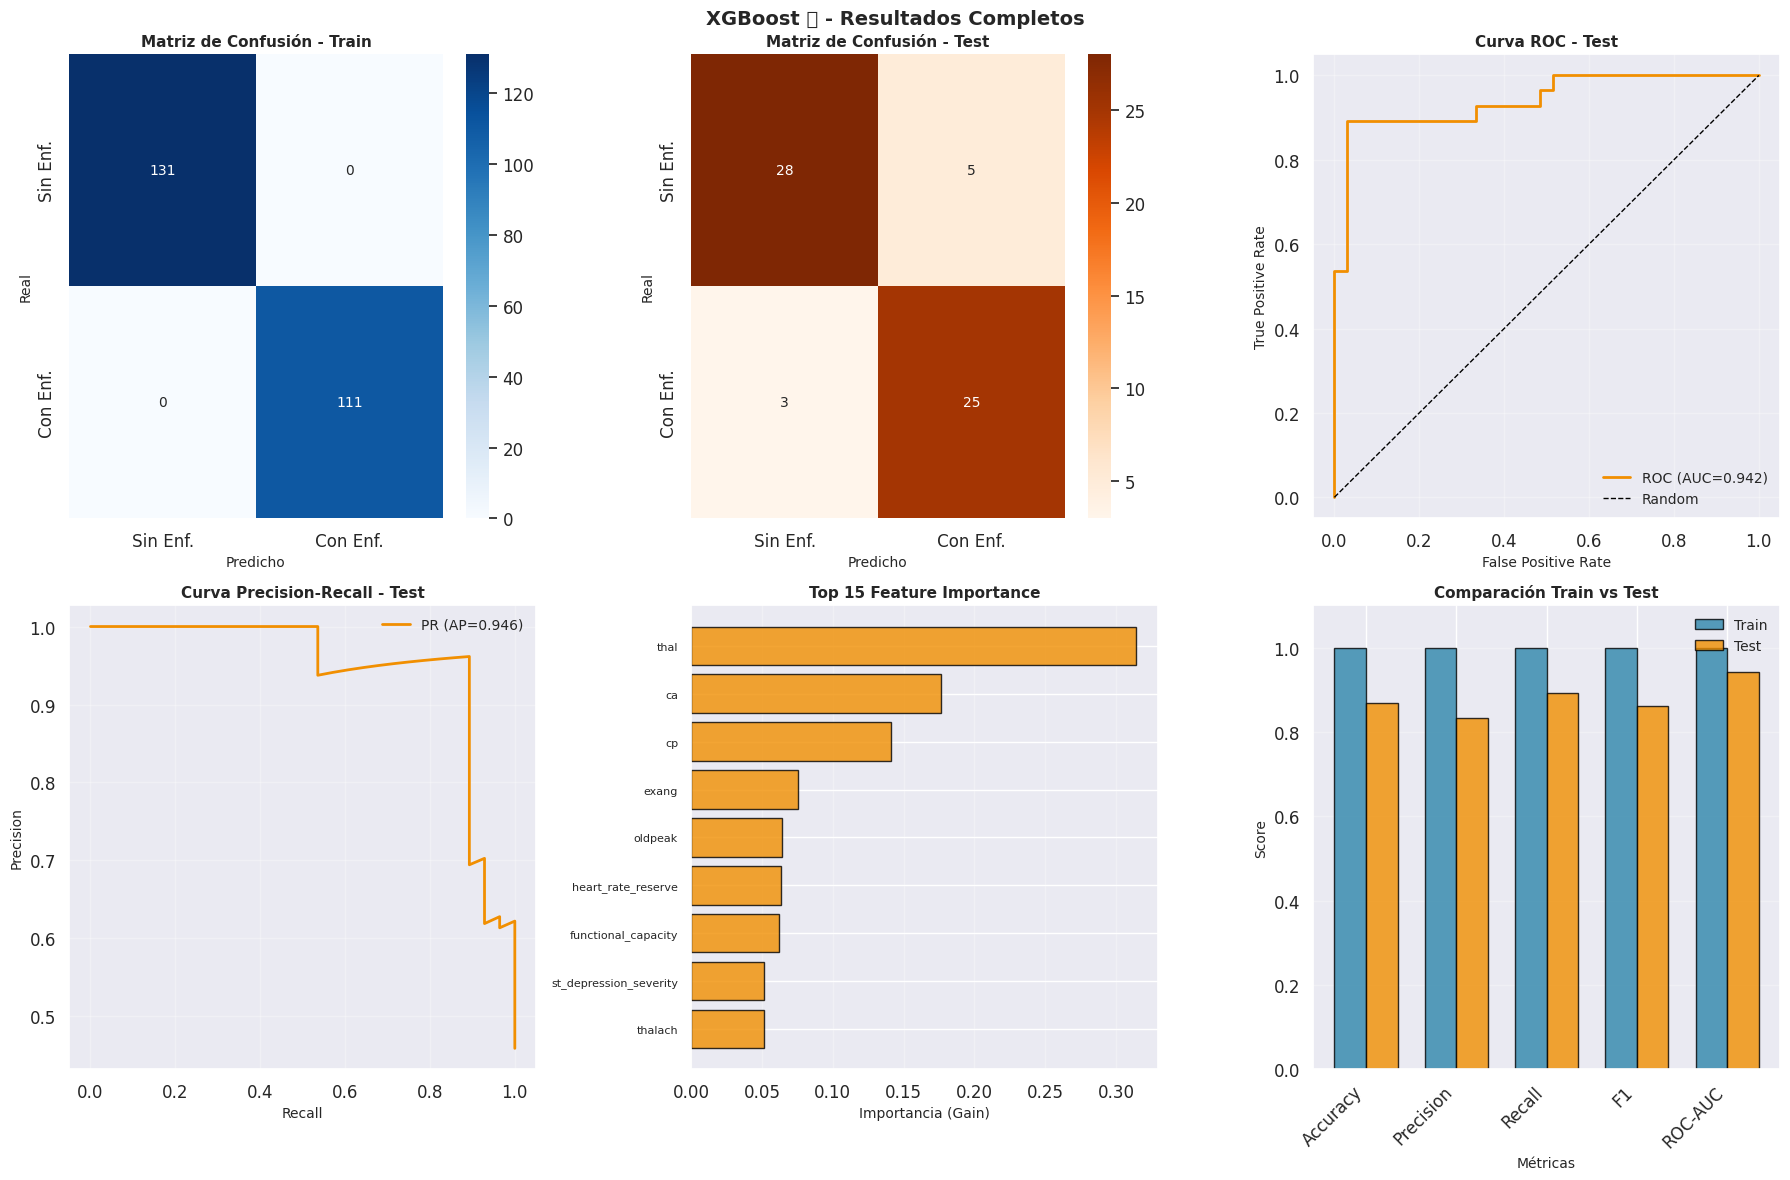

✓ Figura guardada: outputs/17_xgboost_results.png

🔍 ANÁLISIS DE OVERFITTING:

Diferencia Train - Test (Gap):
--------------------------------------------------------------------------------
   • Accuracy    : +0.1311  ⚠️  Revisar
   • Precision   : +0.1667  ❌ Overfitting
   • Recall      : +0.1071  ⚠️  Revisar
   • F1-Score    : +0.1379  ⚠️  Revisar
   • ROC-AUC     : +0.0584  ✅ OK

Gap promedio: 0.1203
⚠️  Ligero overfitting - Considerar más regularización

✓ Modelo guardado: models/xgboost.pkl

RESUMEN: XGBOOST ⭐


,Métrica,Train,Test,Gap
0,Accuracy,1.0,0.8689,0.1311
1,Precision,1.0,0.8333,0.1667
2,Recall,1.0,0.8929,0.1071
3,F1-Score,1.0,0.8621,0.1379
4,ROC-AUC,1.0,0.9416,0.0584
5,Sensitivity,1.0,0.8929,0.1071
6,Specificity,1.0,0.8485,0.1515
7,PPV,1.0,0.8333,0.1667
8,NPV,1.0,0.9032,0.0968



✅ XGBoost completado:
   • Tiempo de entrenamiento: 1.73s
   • N estimators (best): 200
   • ROC-AUC (Test): 0.9416
   • Sensibilidad (Test): 0.8929
   • Especificidad (Test): 0.8485
   • Gap promedio: 0.1203


📊 COMPARACIÓN: LR vs RF vs XGBoost


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Sensitivity,Specificity
0,Logistic Regression,0.8689,0.8125,0.9286,0.8667,0.9394,0.9286,0.8182
1,Random Forest,0.8689,0.8333,0.8929,0.8621,0.9459,0.8929,0.8485
2,XGBoost ⭐,0.8689,0.8333,0.8929,0.8621,0.9416,0.8929,0.8485



🏆 Mejor modelo hasta ahora: Random Forest
   ROC-AUC: 0.9459


In [28]:
# ============================================================================
# 6.3 XGBOOST
# ============================================================================

print("\n" + "="*80)
print("6.3 MODELO 3: XGBOOST ⭐ [RECOMENDADO]")
print("="*80)

# ----------------------------------------------------------------------------
# 6.3.1 Configuración del Modelo
# ----------------------------------------------------------------------------

print("\n🔧 Configuración del modelo:")
print("-"*80)

# Usar datos SIN ESCALAR para XGBoost
X_train_xgb = X_train_final_no_scaled.copy()
X_test_xgb = X_test_final_no_scaled.copy()

# Calcular scale_pos_weight para manejar desbalanceo
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Configurar modelo
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=N_JOBS
)

print("✓ Modelo configurado:")
print(f"   • N estimators: 200")
print(f"   • Max depth: 6")
print(f"   • Learning rate: 0.1")
print(f"   • Subsample: 0.8")
print(f"   • Colsample bytree: 0.8")
print(f"   • Gamma (min split loss): 0.1")
print(f"   • Reg alpha (L1): 0.1")
print(f"   • Reg lambda (L2): 1.0")
print(f"   • Scale pos weight: {scale_pos_weight:.3f}")
print(f"   • Random state: {RANDOM_STATE}")
print(f"   • Dataset: SIN ESCALAR (original)")

# ============================================================================
# 6.3.2 Entrenamiento con Early Stopping - CORREGIDO
# ============================================================================

print("\n🎯 Entrenando modelo con early stopping...")
print("-"*80)

start_time = time()

# Crear conjunto de validación para early stopping
X_train_xgb_split, X_val_xgb, y_train_xgb_split, y_val_xgb = train_test_split(
    X_train_xgb, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

# CORRECCIÓN: Usar eval_set con callbacks en lugar de early_stopping_rounds como argumento directo
xgb_model.fit(
    X_train_xgb_split, y_train_xgb_split,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)

training_time_xgb = time() - start_time

# Obtener el mejor número de iteraciones
# NOTA: En versiones nuevas de XGBoost, si no hay early stopping,
# usaremos todas las iteraciones
try:
    best_iteration = xgb_model.best_iteration
    print(f"✓ Mejor iteración encontrada: {best_iteration}")
except AttributeError:
    # Si no hay best_iteration, usar n_estimators
    best_iteration = xgb_model.n_estimators
    print(f"✓ Usando todas las iteraciones: {best_iteration}")

print(f"   Reentrenando con todos los datos...")

# Re-entrenar con todos los datos
xgb_model_final = xgb.XGBClassifier(
    n_estimators=best_iteration,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=N_JOBS
)

xgb_model_final.fit(X_train_xgb, y_train)

print(f"✓ Modelo entrenado en {training_time_xgb:.2f} segundos")
print(f"   • N estimators final: {best_iteration}")

# Usar el modelo final para todo lo demás
xgb_model = xgb_model_final
# ----------------------------------------------------------------------------
# 6.3.3 Validación Cruzada
# ----------------------------------------------------------------------------

print("\n📊 Validación Cruzada (StratifiedKFold, k=5):")
print("-"*80)

cv_results_xgb = {}

for metric in scoring_metrics:
    scores = cross_val_score(xgb_model, X_train_xgb, y_train, cv=cv, scoring=metric, n_jobs=N_JOBS)
    cv_results_xgb[metric] = scores
    print(f"   • {metric.upper():12s}: {scores.mean():.4f} (±{scores.std():.4f})")

# ----------------------------------------------------------------------------
# 6.3.4 Predicciones
# ----------------------------------------------------------------------------

print("\n🔮 Generando predicciones...")
print("-"*80)

# Predicciones en train
y_train_pred_xgb = xgb_model.predict(X_train_xgb)
y_train_proba_xgb = xgb_model.predict_proba(X_train_xgb)[:, 1]

# Predicciones en test
y_test_pred_xgb = xgb_model.predict(X_test_xgb)
y_test_proba_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

print("✓ Predicciones generadas para train y test")

# ----------------------------------------------------------------------------
# 6.3.5 Evaluación - Train Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TRAINING SET:")
print("="*80)

# Métricas básicas
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
train_precision_xgb = precision_score(y_train, y_train_pred_xgb)
train_recall_xgb = recall_score(y_train, y_train_pred_xgb)
train_f1_xgb = f1_score(y_train, y_train_pred_xgb)
train_roc_auc_xgb = roc_auc_score(y_train, y_train_proba_xgb)

# Matriz de confusión
cm_train_xgb = confusion_matrix(y_train, y_train_pred_xgb)
tn_train_xgb, fp_train_xgb, fn_train_xgb, tp_train_xgb = cm_train_xgb.ravel()

# Métricas clínicas
train_sensitivity_xgb = tp_train_xgb / (tp_train_xgb + fn_train_xgb)
train_specificity_xgb = tn_train_xgb / (tn_train_xgb + fp_train_xgb)
train_ppv_xgb = tp_train_xgb / (tp_train_xgb + fp_train_xgb)
train_npv_xgb = tn_train_xgb / (tn_train_xgb + fn_train_xgb)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {train_accuracy_xgb:.4f}")
print(f"   • Precision: {train_precision_xgb:.4f}")
print(f"   • Recall:    {train_recall_xgb:.4f}")
print(f"   • F1-Score:  {train_f1_xgb:.4f}")
print(f"   • ROC-AUC:   {train_roc_auc_xgb:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {train_sensitivity_xgb:.4f}")
print(f"   • Especificidad (Specificity): {train_specificity_xgb:.4f}")
print(f"   • VPP (PPV):                   {train_ppv_xgb:.4f}")
print(f"   • VPN (NPV):                   {train_npv_xgb:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_train_xgb:3d}  |  FP: {fp_train_xgb:3d}")
print(f"   FN: {fn_train_xgb:3d}  |  TP: {tp_train_xgb:3d}")

# ----------------------------------------------------------------------------
# 6.3.6 Evaluación - Test Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TEST SET:")
print("="*80)

# Métricas básicas
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_precision_xgb = precision_score(y_test, y_test_pred_xgb)
test_recall_xgb = recall_score(y_test, y_test_pred_xgb)
test_f1_xgb = f1_score(y_test, y_test_pred_xgb)
test_roc_auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)

# Matriz de confusión
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)
tn_test_xgb, fp_test_xgb, fn_test_xgb, tp_test_xgb = cm_test_xgb.ravel()

# Métricas clínicas
test_sensitivity_xgb = tp_test_xgb / (tp_test_xgb + fn_test_xgb)
test_specificity_xgb = tn_test_xgb / (tn_test_xgb + fp_test_xgb)
test_ppv_xgb = tp_test_xgb / (tp_test_xgb + fp_test_xgb)
test_npv_xgb = tn_test_xgb / (tn_test_xgb + fn_test_xgb)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {test_accuracy_xgb:.4f}")
print(f"   • Precision: {test_precision_xgb:.4f}")
print(f"   • Recall:    {test_recall_xgb:.4f}")
print(f"   • F1-Score:  {test_f1_xgb:.4f}")
print(f"   • ROC-AUC:   {test_roc_auc_xgb:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {test_sensitivity_xgb:.4f}")
print(f"   • Especificidad (Specificity): {test_specificity_xgb:.4f}")
print(f"   • VPP (PPV):                   {test_ppv_xgb:.4f}")
print(f"   • VPN (NPV):                   {test_npv_xgb:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_test_xgb:3d}  |  FP: {fp_test_xgb:3d}")
print(f"   FN: {fn_test_xgb:3d}  |  TP: {tp_test_xgb:3d}")

# ----------------------------------------------------------------------------
# 6.3.7 Feature Importance (3 tipos)
# ----------------------------------------------------------------------------

print("\n📊 FEATURE IMPORTANCE (3 métodos):")
print("="*80)

# Método 1: Gain (default de XGBoost)
feature_importance_gain = pd.DataFrame({
    'Feature': selected_features,
    'Importance_Gain': xgb_model.feature_importances_
}).sort_values('Importance_Gain', ascending=False)

print("\n1️⃣  Feature Importance - GAIN (reducción promedio de pérdida):")
print("-"*80)
for idx, row in feature_importance_gain.head(10).iterrows():
    print(f"   {row['Feature']:25s}: {row['Importance_Gain']:.4f}")

# Método 2: Weight (frecuencia de uso)
importance_weight = xgb_model.get_booster().get_score(importance_type='weight')
feature_importance_weight = pd.DataFrame({
    'Feature': list(importance_weight.keys()),
    'Importance_Weight': list(importance_weight.values())
}).sort_values('Importance_Weight', ascending=False)

# Mapear f0, f1, ... a nombres reales
feature_map = {f'f{i}': feat for i, feat in enumerate(selected_features)}
feature_importance_weight['Feature'] = feature_importance_weight['Feature'].map(feature_map)

print("\n2️⃣  Feature Importance - WEIGHT (frecuencia de splits):")
print("-"*80)
for idx, row in feature_importance_weight.head(10).iterrows():
    print(f"   {row['Feature']:25}: {row['Importance_Weight']:.0f}")

# Método 3: Cover (cobertura promedio de ejemplos)
importance_cover = xgb_model.get_booster().get_score(importance_type='cover')
feature_importance_cover = pd.DataFrame({
    'Feature': list(importance_cover.keys()),
    'Importance_Cover': list(importance_cover.values())
}).sort_values('Importance_Cover', ascending=False)
feature_importance_cover['Feature'] = feature_importance_cover['Feature'].map(feature_map)

print("\n3️⃣  Feature Importance - COVER (cobertura de ejemplos):")
print("-"*80)
for idx, row in feature_importance_cover.head(10).iterrows():
    print(f"   {row['Feature']:25}: {row['Importance_Cover']:.0f}")

# ----------------------------------------------------------------------------
# 6.3.8 Visualización
# ----------------------------------------------------------------------------

print("\n📊 Generando visualizaciones...")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Matriz de Confusión - Train
sns.heatmap(cm_train_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 0].set_title('Matriz de Confusión - Train', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Real', fontsize=10)
axes[0, 0].set_xlabel('Predicho', fontsize=10)

# 2. Matriz de Confusión - Test
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 1].set_title('Matriz de Confusión - Test', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Real', fontsize=10)
axes[0, 1].set_xlabel('Predicho', fontsize=10)

# 3. ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
axes[0, 2].plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'ROC (AUC={test_roc_auc_xgb:.3f})', color=COLOR_PALETTE[2])
axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 2].set_xlabel('False Positive Rate', fontsize=10)
axes[0, 2].set_ylabel('True Positive Rate', fontsize=10)
axes[0, 2].set_title('Curva ROC - Test', fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Precision-Recall Curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_proba_xgb)
ap_xgb = average_precision_score(y_test, y_test_proba_xgb)
axes[1, 0].plot(recall_xgb, precision_xgb, linewidth=2, label=f'PR (AP={ap_xgb:.3f})', color=COLOR_PALETTE[2])
axes[1, 0].set_xlabel('Recall', fontsize=10)
axes[1, 0].set_ylabel('Precision', fontsize=10)
axes[1, 0].set_title('Curva Precision-Recall - Test', fontsize=11, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Feature Importance (Gain)
top_features_xgb = feature_importance_gain.head(15).sort_values('Importance_Gain')
axes[1, 1].barh(range(len(top_features_xgb)), top_features_xgb['Importance_Gain'],
                color=COLOR_PALETTE[2], alpha=0.8, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features_xgb)))
axes[1, 1].set_yticklabels(top_features_xgb['Feature'], fontsize=8)
axes[1, 1].set_xlabel('Importancia (Gain)', fontsize=10)
axes[1, 1].set_title('Top 15 Feature Importance', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

# 6. Comparación Train vs Test
train_scores_xgb = [train_accuracy_xgb, train_precision_xgb, train_recall_xgb, train_f1_xgb, train_roc_auc_xgb]
test_scores_xgb = [test_accuracy_xgb, test_precision_xgb, test_recall_xgb, test_f1_xgb, test_roc_auc_xgb]

x_pos = np.arange(len(metrics_comparison))
width = 0.35

axes[1, 2].bar(x_pos - width/2, train_scores_xgb, width, label='Train',
               color=COLOR_PALETTE[0], alpha=0.8, edgecolor='black')
axes[1, 2].bar(x_pos + width/2, test_scores_xgb, width, label='Test',
               color=COLOR_PALETTE[2], alpha=0.8, edgecolor='black')
axes[1, 2].set_xlabel('Métricas', fontsize=10)
axes[1, 2].set_ylabel('Score', fontsize=10)
axes[1, 2].set_title('Comparación Train vs Test', fontsize=11, fontweight='bold')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_comparison, rotation=45, ha='right')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3, axis='y')
axes[1, 2].set_ylim([0, 1.1])

plt.suptitle('XGBoost ⭐ - Resultados Completos', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/17_xgboost_results.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/17_xgboost_results.png")

# ----------------------------------------------------------------------------
# 6.3.9 Análisis de Overfitting
# ----------------------------------------------------------------------------

print("\n🔍 ANÁLISIS DE OVERFITTING:")
print("="*80)

overfitting_gap_xgb = {
    'Accuracy': train_accuracy_xgb - test_accuracy_xgb,
    'Precision': train_precision_xgb - test_precision_xgb,
    'Recall': train_recall_xgb - test_recall_xgb,
    'F1-Score': train_f1_xgb - test_f1_xgb,
    'ROC-AUC': train_roc_auc_xgb - test_roc_auc_xgb
}

print("\nDiferencia Train - Test (Gap):")
print("-"*80)
for metric, gap in overfitting_gap_xgb.items():
    status = "✅ OK" if abs(gap) < 0.1 else "⚠️  Revisar" if abs(gap) < 0.15 else "❌ Overfitting"
    print(f"   • {metric:12s}: {gap:+.4f}  {status}")

avg_gap_xgb = np.mean([abs(v) for v in overfitting_gap_xgb.values()])
print(f"\nGap promedio: {avg_gap_xgb:.4f}")

if avg_gap_xgb < 0.05:
    print("✅ Modelo generaliza EXCELENTEMENTE")
elif avg_gap_xgb < 0.10:
    print("✅ Modelo generaliza BIEN")
elif avg_gap_xgb < 0.15:
    print("⚠️  Ligero overfitting - Considerar más regularización")
else:
    print("❌ Overfitting significativo - Requiere ajustes")

# ----------------------------------------------------------------------------
# 6.3.10 Guardar Modelo
# ----------------------------------------------------------------------------

model_path_xgb = f'{MODELS_DIR}/xgboost.pkl'
joblib.dump(xgb_model, model_path_xgb)
print(f"\n✓ Modelo guardado: {model_path_xgb}")

# ----------------------------------------------------------------------------
# 6.3.11 Resumen
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("RESUMEN: XGBOOST ⭐")
print("="*80)

summary_xgb = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
                'Sensitivity', 'Specificity', 'PPV', 'NPV'],
    'Train': [train_accuracy_xgb, train_precision_xgb, train_recall_xgb, train_f1_xgb, train_roc_auc_xgb,
              train_sensitivity_xgb, train_specificity_xgb, train_ppv_xgb, train_npv_xgb],
    'Test': [test_accuracy_xgb, test_precision_xgb, test_recall_xgb, test_f1_xgb, test_roc_auc_xgb,
             test_sensitivity_xgb, test_specificity_xgb, test_ppv_xgb, test_npv_xgb],
    'Gap': [train_accuracy_xgb - test_accuracy_xgb,
            train_precision_xgb - test_precision_xgb,
            train_recall_xgb - test_recall_xgb,
            train_f1_xgb - test_f1_xgb,
            train_roc_auc_xgb - test_roc_auc_xgb,
            train_sensitivity_xgb - test_sensitivity_xgb,
            train_specificity_xgb - test_specificity_xgb,
            train_ppv_xgb - test_ppv_xgb,
            train_npv_xgb - test_npv_xgb]
})

display(summary_xgb.round(4))

print(f"""
✅ XGBoost completado:
   • Tiempo de entrenamiento: {training_time_xgb:.2f}s
   • N estimators (best): {best_iteration}
   • ROC-AUC (Test): {test_roc_auc_xgb:.4f}
   • Sensibilidad (Test): {test_sensitivity_xgb:.4f}
   • Especificidad (Test): {test_specificity_xgb:.4f}
   • Gap promedio: {avg_gap_xgb:.4f}
""")

print("="*80)

# ----------------------------------------------------------------------------
# 6.3.12 Comparación LR vs RF vs XGB
# ----------------------------------------------------------------------------

print("\n📊 COMPARACIÓN: LR vs RF vs XGBoost")
print("="*80)

comparison_3models = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest', 'XGBoost ⭐'],
    'Accuracy': [test_accuracy_lr, test_accuracy_rf, test_accuracy_xgb],
    'Precision': [test_precision_lr, test_precision_rf, test_precision_xgb],
    'Recall': [test_recall_lr, test_recall_rf, test_recall_xgb],
    'F1-Score': [test_f1_lr, test_f1_rf, test_f1_xgb],
    'ROC-AUC': [test_roc_auc_lr, test_roc_auc_rf, test_roc_auc_xgb],
    'Sensitivity': [test_sensitivity_lr, test_sensitivity_rf, test_sensitivity_xgb],
    'Specificity': [test_specificity_lr, test_specificity_rf, test_specificity_xgb]
})

display(comparison_3models.round(4))

# Identificar mejor modelo
best_model_idx = comparison_3models['ROC-AUC'].idxmax()
best_model_name = comparison_3models.loc[best_model_idx, 'Modelo']
best_roc_auc = comparison_3models.loc[best_model_idx, 'ROC-AUC']

print(f"\n🏆 Mejor modelo hasta ahora: {best_model_name}")
print(f"   ROC-AUC: {best_roc_auc:.4f}")

print("="*80)

avg_gap_xgb = np.mean([
    abs(train_accuracy_xgb - test_accuracy_xgb),
    abs(train_roc_auc_xgb - test_roc_auc_xgb),
    abs(train_recall_xgb - test_recall_xgb)
])

<a id='64-lightgbm'></a>
## 6.4 Modelo 4: LightGBM

### Descripción del Modelo

**LightGBM (Light Gradient Boosting Machine)** es un framework de gradient boosting desarrollado por Microsoft que utiliza algoritmos de crecimiento de árboles basados en hojas (leaf-wise) en lugar de nivel por nivel (level-wise). Esto lo hace extremadamente eficiente en memoria y velocidad.

**Ventajas en contexto clínico:**
- Extremadamente rápido en entrenamiento
- Eficiente en uso de memoria
- Excelente con datasets grandes
- Manejo nativo de features categóricas
- Buena precisión con menos iteraciones

**Desventajas:**
- Más propenso a overfitting en datasets pequeños
- Requiere ajuste cuidadoso de hiperparámetros
- Menos documentación que XGBoost

**Diferencia clave vs XGBoost:**
- XGBoost: Crece árboles nivel por nivel (más conservador)
- LightGBM: Crece árboles hoja por hoja (más agresivo, más rápido)


6.4 MODELO 4: LIGHTGBM 💡

🔧 Configuración del modelo:
--------------------------------------------------------------------------------
✓ Modelo configurado:
   • N estimators: 200
   • Max depth: 7
   • Learning rate: 0.05
   • Num leaves: 31
   • Subsample: 0.8
   • Colsample bytree: 0.8
   • Reg alpha (L1): 0.1
   • Reg lambda (L2): 0.1
   • Min child samples: 10
   • Class weight: balanced
   • Random state: 42
   • Dataset: SIN ESCALAR (original)

🎯 Entrenando modelo con early stopping...
--------------------------------------------------------------------------------
✓ Mejor iteración encontrada: 7
   Reentrenando con todos los datos...
✓ Modelo entrenado en 0.38 segundos
   • N estimators final: 7

📊 Validación Cruzada (StratifiedKFold, k=5):
--------------------------------------------------------------------------------
   • ACCURACY    : 0.8015 (±0.0179)
   • PRECISION   : 0.7789 (±0.0431)
   • RECALL      : 0.8008 (±0.0631)
   • F1          : 0.7867 (±0.0202)
   • ROC_AUC   

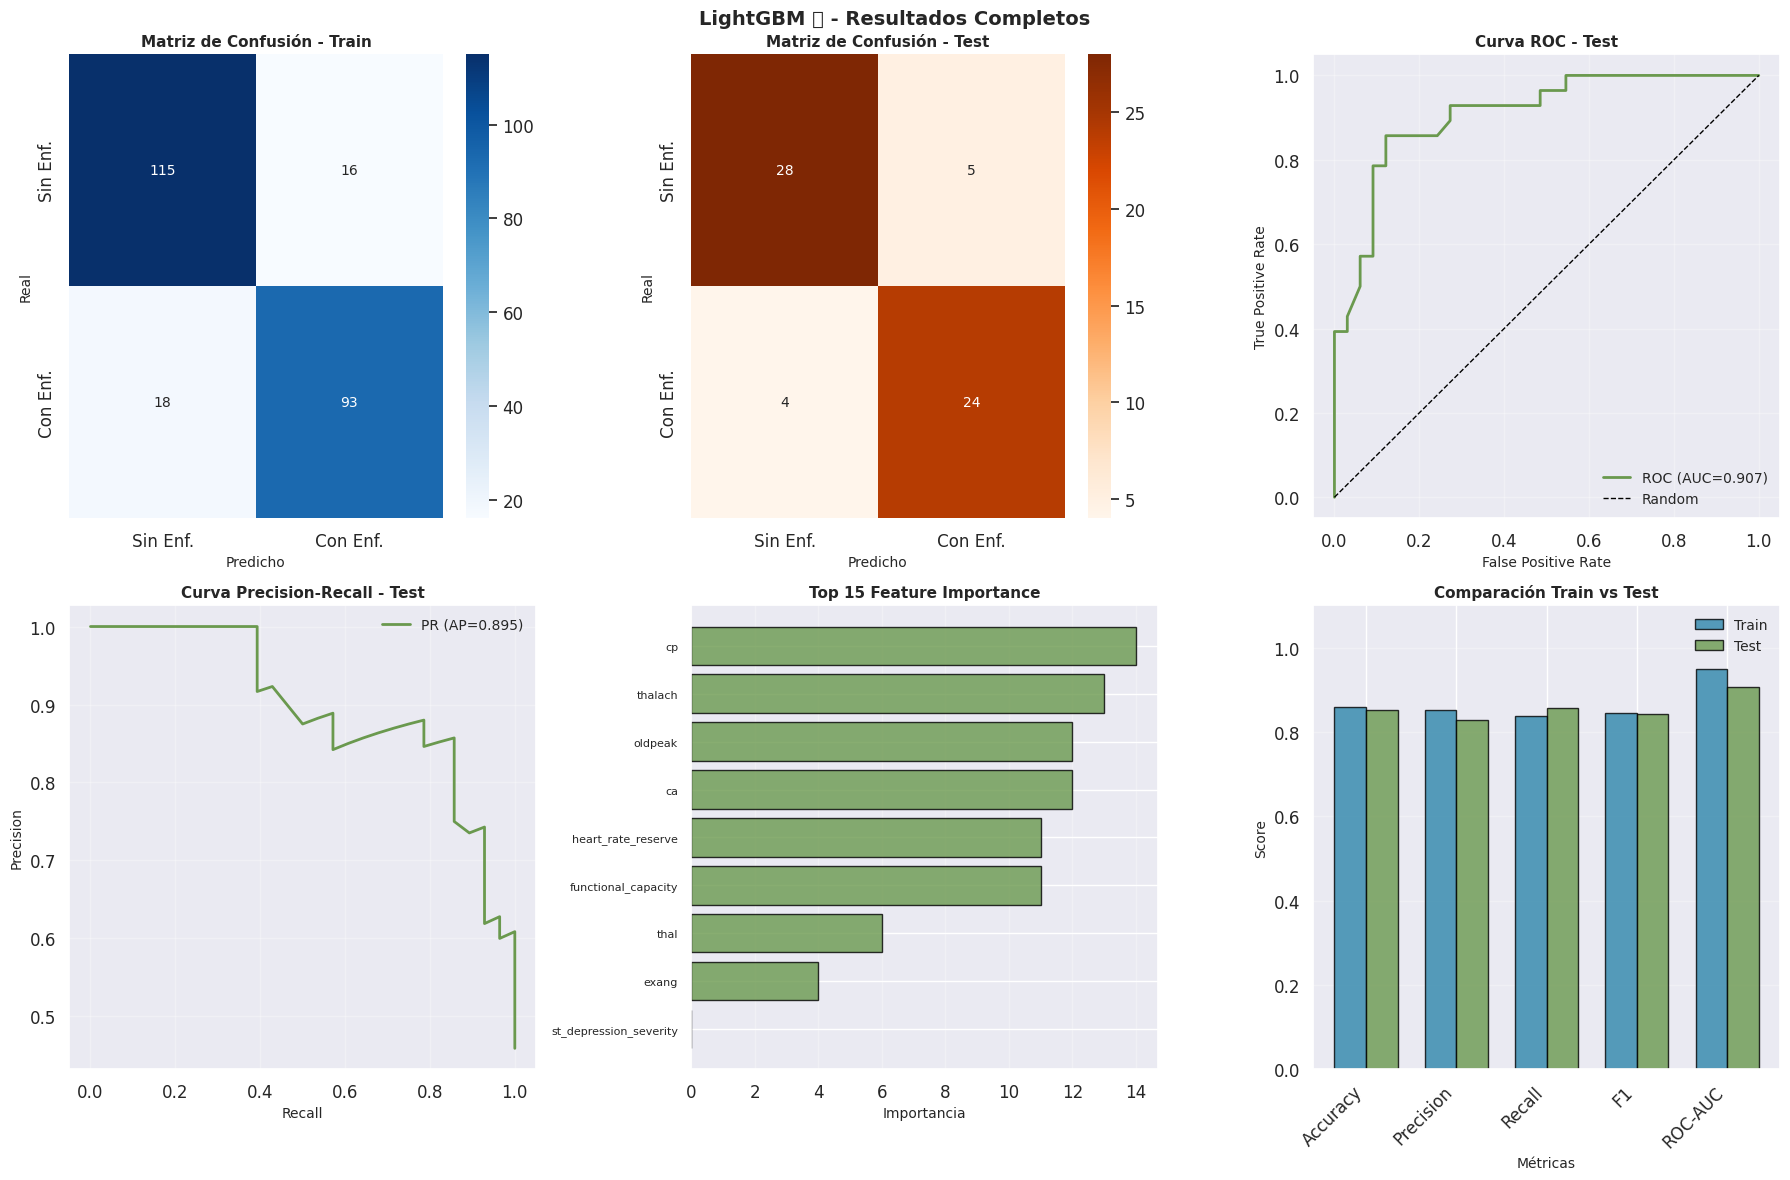

✓ Figura guardada: outputs/18_lightgbm_results.png

🔍 ANÁLISIS DE OVERFITTING:

Diferencia Train - Test (Gap):
--------------------------------------------------------------------------------
   • Accuracy    : +0.0070  ✅ OK
   • Precision   : +0.0256  ✅ OK
   • Recall      : -0.0193  ✅ OK
   • F1-Score    : +0.0033  ✅ OK
   • ROC-AUC     : +0.0412  ✅ OK

Gap promedio: 0.0193
✅ Modelo generaliza EXCELENTEMENTE

✓ Modelo guardado: models/lightgbm.pkl

RESUMEN: LIGHTGBM 💡


,Métrica,Train,Test,Gap
0,Accuracy,0.8595,0.8525,0.0070
1,Precision,0.8532,0.8276,0.0256
2,Recall,0.8378,0.8571,-0.0193
3,F1-Score,0.8455,0.8421,0.0033
4,ROC-AUC,0.9486,0.9075,0.0412
5,Sensitivity,0.8378,0.8571,-0.0193
6,Specificity,0.8779,0.8485,0.0294
7,PPV,0.8532,0.8276,0.0256
8,NPV,0.8647,0.8750,-0.0103



✅ LightGBM completado:
   • Tiempo de entrenamiento: 0.38s
   • N estimators (best): 7
   • ROC-AUC (Test): 0.9075
   • Sensibilidad (Test): 0.8571
   • Especificidad (Test): 0.8485
   • Gap promedio: 0.0193


📊 COMPARACIÓN: LR vs RF vs XGBoost vs LightGBM


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Sensitivity,Specificity,Training Time (s)
0,Logistic Regression,0.8689,0.8125,0.9286,0.8667,0.9394,0.9286,0.8182,0.0165
1,Random Forest,0.8689,0.8333,0.8929,0.8621,0.9459,0.8929,0.8485,0.4800
2,XGBoost ⭐,0.8689,0.8333,0.8929,0.8621,0.9416,0.8929,0.8485,1.7267
3,LightGBM 💡,0.8525,0.8276,0.8571,0.8421,0.9075,0.8571,0.8485,0.3808



🏆 Ranking de Modelos (por ROC-AUC):
--------------------------------------------------------------------------------
🥈 Random Forest            : ROC-AUC = 0.9459
🥉 XGBoost ⭐                : ROC-AUC = 0.9416
🥇 Logistic Regression      : ROC-AUC = 0.9394
   LightGBM 💡               : ROC-AUC = 0.9075


In [29]:
# ============================================================================
# 6.4 LIGHTGBM
# ============================================================================

print("\n" + "="*80)
print("6.4 MODELO 4: LIGHTGBM 💡")
print("="*80)

# ----------------------------------------------------------------------------
# 6.4.1 Configuración del Modelo
# ----------------------------------------------------------------------------

print("\n🔧 Configuración del modelo:")
print("-"*80)

# Usar datos SIN ESCALAR para LightGBM
X_train_lgb = X_train_final_no_scaled.copy()
X_test_lgb = X_test_final_no_scaled.copy()

# Configurar modelo
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_samples=10,
    random_state=RANDOM_STATE,
    verbose=-1,
    class_weight='balanced',
    n_jobs=N_JOBS
)

print("✓ Modelo configurado:")
print(f"   • N estimators: 200")
print(f"   • Max depth: 7")
print(f"   • Learning rate: 0.05")
print(f"   • Num leaves: 31")
print(f"   • Subsample: 0.8")
print(f"   • Colsample bytree: 0.8")
print(f"   • Reg alpha (L1): 0.1")
print(f"   • Reg lambda (L2): 0.1")
print(f"   • Min child samples: 10")
print(f"   • Class weight: balanced")
print(f"   • Random state: {RANDOM_STATE}")
print(f"   • Dataset: SIN ESCALAR (original)")

# ============================================================================
# 6.4.2 Entrenamiento con Early Stopping - CORREGIDO
# ============================================================================

print("\n🎯 Entrenando modelo con early stopping...")
print("-"*80)

start_time = time()

# Crear conjunto de validación
X_train_lgb_split, X_val_lgb, y_train_lgb_split, y_val_lgb = train_test_split(
    X_train_lgb, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

# CORRECCIÓN: LightGBM soporta callbacks
from lightgbm import early_stopping

lgb_model.fit(
    X_train_lgb_split, y_train_lgb_split,
    eval_set=[(X_val_lgb, y_val_lgb)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=20, verbose=False)]
)

training_time_lgb = time() - start_time

# Obtener mejor iteración
try:
    best_iteration_lgb = lgb_model.best_iteration_
    print(f"✓ Mejor iteración encontrada: {best_iteration_lgb}")
except AttributeError:
    best_iteration_lgb = lgb_model.n_estimators
    print(f"✓ Usando todas las iteraciones: {best_iteration_lgb}")

print(f"   Reentrenando con todos los datos...")

# Re-entrenar con todos los datos
lgb_model_final = lgb.LGBMClassifier(
    n_estimators=best_iteration_lgb,
    max_depth=7,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_samples=10,
    random_state=RANDOM_STATE,
    verbose=-1,
    class_weight='balanced',
    n_jobs=N_JOBS
)

lgb_model_final.fit(X_train_lgb, y_train)

print(f"✓ Modelo entrenado en {training_time_lgb:.2f} segundos")
print(f"   • N estimators final: {best_iteration_lgb}")

lgb_model = lgb_model_final
# ----------------------------------------------------------------------------
# 6.4.3 Validación Cruzada
# ----------------------------------------------------------------------------

print("\n📊 Validación Cruzada (StratifiedKFold, k=5):")
print("-"*80)

cv_results_lgb = {}

for metric in scoring_metrics:
    scores = cross_val_score(lgb_model, X_train_lgb, y_train, cv=cv, scoring=metric, n_jobs=N_JOBS)
    cv_results_lgb[metric] = scores
    print(f"   • {metric.upper():12s}: {scores.mean():.4f} (±{scores.std():.4f})")

# ----------------------------------------------------------------------------
# 6.4.4 Predicciones
# ----------------------------------------------------------------------------

print("\n🔮 Generando predicciones...")
print("-"*80)

# Predicciones en train
y_train_pred_lgb = lgb_model.predict(X_train_lgb)
y_train_proba_lgb = lgb_model.predict_proba(X_train_lgb)[:, 1]

# Predicciones en test
y_test_pred_lgb = lgb_model.predict(X_test_lgb)
y_test_proba_lgb = lgb_model.predict_proba(X_test_lgb)[:, 1]

print("✓ Predicciones generadas para train y test")

# ----------------------------------------------------------------------------
# 6.4.5 Evaluación - Train Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TRAINING SET:")
print("="*80)

# Métricas básicas
train_accuracy_lgb = accuracy_score(y_train, y_train_pred_lgb)
train_precision_lgb = precision_score(y_train, y_train_pred_lgb)
train_recall_lgb = recall_score(y_train, y_train_pred_lgb)
train_f1_lgb = f1_score(y_train, y_train_pred_lgb)
train_roc_auc_lgb = roc_auc_score(y_train, y_train_proba_lgb)

# Matriz de confusión
cm_train_lgb = confusion_matrix(y_train, y_train_pred_lgb)
tn_train_lgb, fp_train_lgb, fn_train_lgb, tp_train_lgb = cm_train_lgb.ravel()

# Métricas clínicas
train_sensitivity_lgb = tp_train_lgb / (tp_train_lgb + fn_train_lgb)
train_specificity_lgb = tn_train_lgb / (tn_train_lgb + fp_train_lgb)
train_ppv_lgb = tp_train_lgb / (tp_train_lgb + fp_train_lgb)
train_npv_lgb = tn_train_lgb / (tn_train_lgb + fn_train_lgb)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {train_accuracy_lgb:.4f}")
print(f"   • Precision: {train_precision_lgb:.4f}")
print(f"   • Recall:    {train_recall_lgb:.4f}")
print(f"   • F1-Score:  {train_f1_lgb:.4f}")
print(f"   • ROC-AUC:   {train_roc_auc_lgb:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {train_sensitivity_lgb:.4f}")
print(f"   • Especificidad (Specificity): {train_specificity_lgb:.4f}")
print(f"   • VPP (PPV):                   {train_ppv_lgb:.4f}")
print(f"   • VPN (NPV):                   {train_npv_lgb:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_train_lgb:3d}  |  FP: {fp_train_lgb:3d}")
print(f"   FN: {fn_train_lgb:3d}  |  TP: {tp_train_lgb:3d}")

# ----------------------------------------------------------------------------
# 6.4.6 Evaluación - Test Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TEST SET:")
print("="*80)

# Métricas básicas
test_accuracy_lgb = accuracy_score(y_test, y_test_pred_lgb)
test_precision_lgb = precision_score(y_test, y_test_pred_lgb)
test_recall_lgb = recall_score(y_test, y_test_pred_lgb)
test_f1_lgb = f1_score(y_test, y_test_pred_lgb)
test_roc_auc_lgb = roc_auc_score(y_test, y_test_proba_lgb)

# Matriz de confusión
cm_test_lgb = confusion_matrix(y_test, y_test_pred_lgb)
tn_test_lgb, fp_test_lgb, fn_test_lgb, tp_test_lgb = cm_test_lgb.ravel()

# Métricas clínicas
test_sensitivity_lgb = tp_test_lgb / (tp_test_lgb + fn_test_lgb)
test_specificity_lgb = tn_test_lgb / (tn_test_lgb + fp_test_lgb)
test_ppv_lgb = tp_test_lgb / (tp_test_lgb + fp_test_lgb)
test_npv_lgb = tn_test_lgb / (tn_test_lgb + fn_test_lgb)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {test_accuracy_lgb:.4f}")
print(f"   • Precision: {test_precision_lgb:.4f}")
print(f"   • Recall:    {test_recall_lgb:.4f}")
print(f"   • F1-Score:  {test_f1_lgb:.4f}")
print(f"   • ROC-AUC:   {test_roc_auc_lgb:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {test_sensitivity_lgb:.4f}")
print(f"   • Especificidad (Specificity): {test_specificity_lgb:.4f}")
print(f"   • VPP (PPV):                   {test_ppv_lgb:.4f}")
print(f"   • VPN (NPV):                   {test_npv_lgb:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_test_lgb:3d}  |  FP: {fp_test_lgb:3d}")
print(f"   FN: {fn_test_lgb:3d}  |  TP: {tp_test_lgb:3d}")

# ----------------------------------------------------------------------------
# 6.4.7 Feature Importance
# ----------------------------------------------------------------------------

print("\n📊 FEATURE IMPORTANCE:")
print("="*80)

# LightGBM usa 'split' por defecto (similar a gain)
feature_importance_lgb = pd.DataFrame({
    'Feature': selected_features,
    'Importance': lgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features más importantes:")
print("-"*80)
for idx, row in feature_importance_lgb.head(10).iterrows():
    print(f"   {row['Feature']:25s}: {row['Importance']:.4f}")

# ----------------------------------------------------------------------------
# 6.4.8 Visualización
# ----------------------------------------------------------------------------

print("\n📊 Generando visualizaciones...")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Matriz de Confusión - Train
sns.heatmap(cm_train_lgb, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 0].set_title('Matriz de Confusión - Train', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Real', fontsize=10)
axes[0, 0].set_xlabel('Predicho', fontsize=10)

# 2. Matriz de Confusión - Test
sns.heatmap(cm_test_lgb, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 1].set_title('Matriz de Confusión - Test', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Real', fontsize=10)
axes[0, 1].set_xlabel('Predicho', fontsize=10)

# 3. ROC Curve
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_test_proba_lgb)
axes[0, 2].plot(fpr_lgb, tpr_lgb, linewidth=2, label=f'ROC (AUC={test_roc_auc_lgb:.3f})', color=COLOR_PALETTE[4])
axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 2].set_xlabel('False Positive Rate', fontsize=10)
axes[0, 2].set_ylabel('True Positive Rate', fontsize=10)
axes[0, 2].set_title('Curva ROC - Test', fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Precision-Recall Curve
precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_test_proba_lgb)
ap_lgb = average_precision_score(y_test, y_test_proba_lgb)
axes[1, 0].plot(recall_lgb, precision_lgb, linewidth=2, label=f'PR (AP={ap_lgb:.3f})', color=COLOR_PALETTE[4])
axes[1, 0].set_xlabel('Recall', fontsize=10)
axes[1, 0].set_ylabel('Precision', fontsize=10)
axes[1, 0].set_title('Curva Precision-Recall - Test', fontsize=11, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Feature Importance
top_features_lgb = feature_importance_lgb.head(15).sort_values('Importance')
axes[1, 1].barh(range(len(top_features_lgb)), top_features_lgb['Importance'],
                color=COLOR_PALETTE[4], alpha=0.8, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features_lgb)))
axes[1, 1].set_yticklabels(top_features_lgb['Feature'], fontsize=8)
axes[1, 1].set_xlabel('Importancia', fontsize=10)
axes[1, 1].set_title('Top 15 Feature Importance', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

# 6. Comparación Train vs Test
train_scores_lgb = [train_accuracy_lgb, train_precision_lgb, train_recall_lgb, train_f1_lgb, train_roc_auc_lgb]
test_scores_lgb = [test_accuracy_lgb, test_precision_lgb, test_recall_lgb, test_f1_lgb, test_roc_auc_lgb]

x_pos = np.arange(len(metrics_comparison))
width = 0.35

axes[1, 2].bar(x_pos - width/2, train_scores_lgb, width, label='Train',
               color=COLOR_PALETTE[0], alpha=0.8, edgecolor='black')
axes[1, 2].bar(x_pos + width/2, test_scores_lgb, width, label='Test',
               color=COLOR_PALETTE[4], alpha=0.8, edgecolor='black')
axes[1, 2].set_xlabel('Métricas', fontsize=10)
axes[1, 2].set_ylabel('Score', fontsize=10)
axes[1, 2].set_title('Comparación Train vs Test', fontsize=11, fontweight='bold')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_comparison, rotation=45, ha='right')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3, axis='y')
axes[1, 2].set_ylim([0, 1.1])

plt.suptitle('LightGBM 💡 - Resultados Completos', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/18_lightgbm_results.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/18_lightgbm_results.png")

# ----------------------------------------------------------------------------
# 6.4.9 Análisis de Overfitting
# ----------------------------------------------------------------------------

print("\n🔍 ANÁLISIS DE OVERFITTING:")
print("="*80)

overfitting_gap_lgb = {
    'Accuracy': train_accuracy_lgb - test_accuracy_lgb,
    'Precision': train_precision_lgb - test_precision_lgb,
    'Recall': train_recall_lgb - test_recall_lgb,
    'F1-Score': train_f1_lgb - test_f1_lgb,
    'ROC-AUC': train_roc_auc_lgb - test_roc_auc_lgb
}

print("\nDiferencia Train - Test (Gap):")
print("-"*80)
for metric, gap in overfitting_gap_lgb.items():
    status = "✅ OK" if abs(gap) < 0.1 else "⚠️  Revisar" if abs(gap) < 0.15 else "❌ Overfitting"
    print(f"   • {metric:12s}: {gap:+.4f}  {status}")

avg_gap_lgb = np.mean([abs(v) for v in overfitting_gap_lgb.values()])
print(f"\nGap promedio: {avg_gap_lgb:.4f}")

if avg_gap_lgb < 0.05:
    print("✅ Modelo generaliza EXCELENTEMENTE")
elif avg_gap_lgb < 0.10:
    print("✅ Modelo generaliza BIEN")
elif avg_gap_lgb < 0.15:
    print("⚠️  Ligero overfitting - Considerar más regularización")
else:
    print("❌ Overfitting significativo - Requiere ajustes")

# ----------------------------------------------------------------------------
# 6.4.10 Guardar Modelo
# ----------------------------------------------------------------------------

model_path_lgb = f'{MODELS_DIR}/lightgbm.pkl'
joblib.dump(lgb_model, model_path_lgb)
print(f"\n✓ Modelo guardado: {model_path_lgb}")

# ----------------------------------------------------------------------------
# 6.4.11 Resumen
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("RESUMEN: LIGHTGBM 💡")
print("="*80)

summary_lgb = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
                'Sensitivity', 'Specificity', 'PPV', 'NPV'],
    'Train': [train_accuracy_lgb, train_precision_lgb, train_recall_lgb, train_f1_lgb, train_roc_auc_lgb,
              train_sensitivity_lgb, train_specificity_lgb, train_ppv_lgb, train_npv_lgb],
    'Test': [test_accuracy_lgb, test_precision_lgb, test_recall_lgb, test_f1_lgb, test_roc_auc_lgb,
             test_sensitivity_lgb, test_specificity_lgb, test_ppv_lgb, test_npv_lgb],
    'Gap': [train_accuracy_lgb - test_accuracy_lgb,
            train_precision_lgb - test_precision_lgb,
            train_recall_lgb - test_recall_lgb,
            train_f1_lgb - test_f1_lgb,
            train_roc_auc_lgb - test_roc_auc_lgb,
            train_sensitivity_lgb - test_sensitivity_lgb,
            train_specificity_lgb - test_specificity_lgb,
            train_ppv_lgb - test_ppv_lgb,
            train_npv_lgb - test_npv_lgb]
})

display(summary_lgb.round(4))

print(f"""
✅ LightGBM completado:
   • Tiempo de entrenamiento: {training_time_lgb:.2f}s
   • N estimators (best): {best_iteration_lgb}
   • ROC-AUC (Test): {test_roc_auc_lgb:.4f}
   • Sensibilidad (Test): {test_sensitivity_lgb:.4f}
   • Especificidad (Test): {test_specificity_lgb:.4f}
   • Gap promedio: {avg_gap_lgb:.4f}
""")

print("="*80)

# ----------------------------------------------------------------------------
# 6.4.12 Comparación 4 Modelos
# ----------------------------------------------------------------------------

print("\n📊 COMPARACIÓN: LR vs RF vs XGBoost vs LightGBM")
print("="*80)

comparison_4models = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest', 'XGBoost ⭐', 'LightGBM 💡'],
    'Accuracy': [test_accuracy_lr, test_accuracy_rf, test_accuracy_xgb, test_accuracy_lgb],
    'Precision': [test_precision_lr, test_precision_rf, test_precision_xgb, test_precision_lgb],
    'Recall': [test_recall_lr, test_recall_rf, test_recall_xgb, test_recall_lgb],
    'F1-Score': [test_f1_lr, test_f1_rf, test_f1_xgb, test_f1_lgb],
    'ROC-AUC': [test_roc_auc_lr, test_roc_auc_rf, test_roc_auc_xgb, test_roc_auc_lgb],
    'Sensitivity': [test_sensitivity_lr, test_sensitivity_rf, test_sensitivity_xgb, test_sensitivity_lgb],
    'Specificity': [test_specificity_lr, test_specificity_rf, test_specificity_xgb, test_specificity_lgb],
    'Training Time (s)': [training_time, training_time_rf, training_time_xgb, training_time_lgb]
})

display(comparison_4models.round(4))

# Ranking por ROC-AUC
ranking = comparison_4models.sort_values('ROC-AUC', ascending=False)
print("\n🏆 Ranking de Modelos (por ROC-AUC):")
print("-"*80)
for idx, row in ranking.iterrows():
    medal = "🥇" if idx == 0 else "🥈" if idx == 1 else "🥉" if idx == 2 else "  "
    print(f"{medal} {row['Modelo']:25s}: ROC-AUC = {row['ROC-AUC']:.4f}")

print("="*80)

avg_gap_lgb = np.mean([
    abs(train_accuracy_lgb - test_accuracy_lgb),
    abs(train_roc_auc_lgb - test_roc_auc_lgb),
    abs(train_recall_lgb - test_recall_lgb)
])

<a id='65-catboost'></a>
## 6.5 Modelo 5: CatBoost

### Descripción del Modelo

**CatBoost (Categorical Boosting)** es un algoritmo de gradient boosting desarrollado por Yandex, especializado en el manejo de features categóricas sin necesidad de codificación explícita. Utiliza "Ordered Boosting" para reducir overfitting y predecir mejor en nuevos datos.

**Ventajas en contexto clínico:**
- Excelente manejo de variables categóricas
- Muy robusto a overfitting (ordered boosting)
- Parámetros por defecto muy buenos (menos tuning)
- Resultados competitivos out-of-the-box
- Auto class_weights

**Desventajas:**
- Más lento que LightGBM
- Mayor uso de memoria
- Menos popularidad que XGBoost

**Característica única:**
- No requiere one-hot encoding para categóricas
- Maneja automáticamente combinaciones de features


6.5 MODELO 5: CATBOOST 🐱

🔧 Configuración del modelo:
--------------------------------------------------------------------------------
✓ Features categóricas identificadas y convertidas: 5
   Variables categóricas:
      • thal
      • ca
      • cp
      • exang
      • st_depression_severity

✓ Modelo configurado:
   • Iterations: 200
   • Depth: 6
   • Learning rate: 0.1
   • L2 leaf reg: 3
   • Auto class weights: Balanced
   • Random seed: 42
   • Cat features: 5
   • Dataset: SIN ESCALAR (original)

🎯 Entrenando modelo con early stopping...
--------------------------------------------------------------------------------
✓ Mejor iteración encontrada: 4
   Reentrenando con todos los datos...
✓ Modelo entrenado en 0.22 segundos
   • Iterations final: 4

📊 Validación Cruzada (StratifiedKFold, k=5):
--------------------------------------------------------------------------------
   • ACCURACY    : 0.7685 (±0.0366)
   • PRECISION   : 0.7655 (±0.0817)
   • RECALL      : 0.7379 (±0.0555

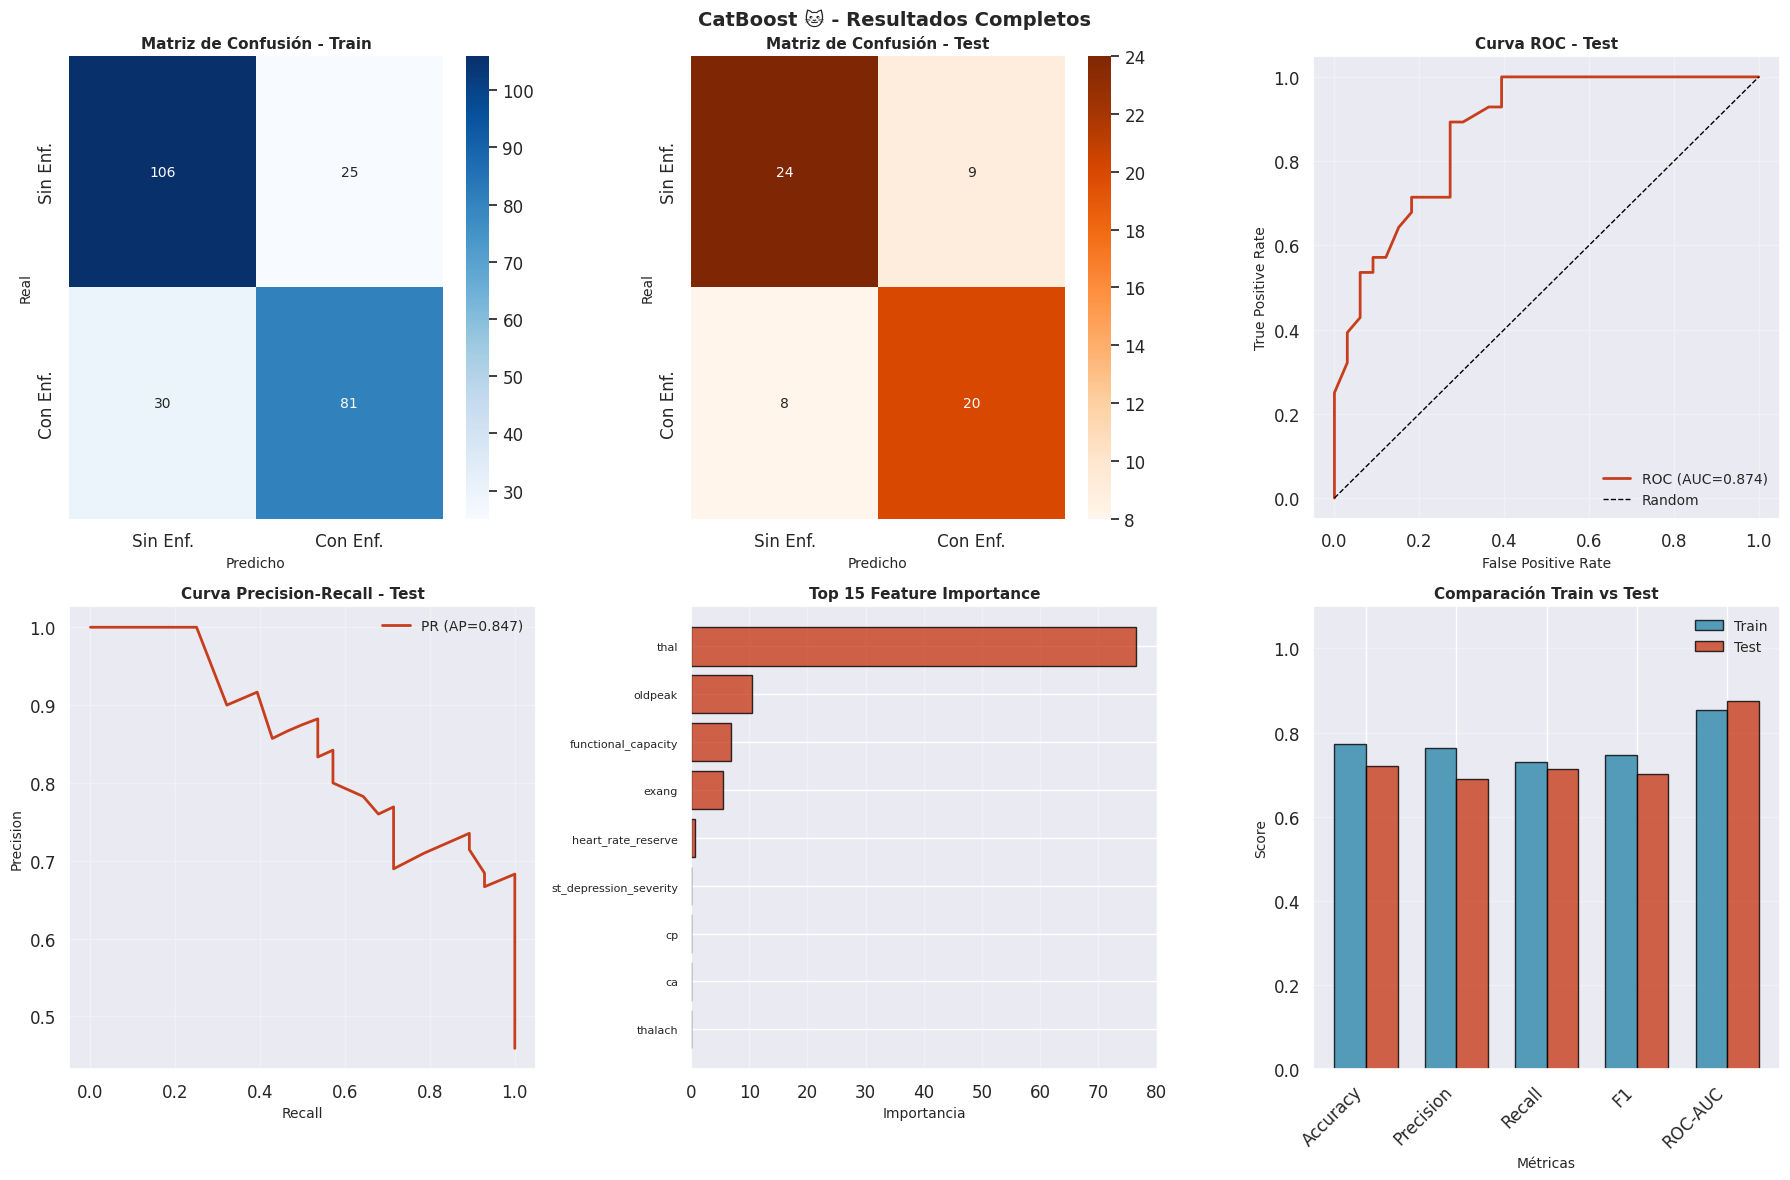

✓ Figura guardada: outputs/19_catboost_results.png

🔍 ANÁLISIS DE OVERFITTING:

Diferencia Train - Test (Gap):
--------------------------------------------------------------------------------
   • Accuracy    : +0.0514  ✅ OK
   • Precision   : +0.0745  ✅ OK
   • Recall      : +0.0154  ✅ OK
   • F1-Score    : +0.0448  ✅ OK
   • ROC-AUC     : -0.0220  ✅ OK

Gap promedio: 0.0416
✅ Modelo generaliza EXCELENTEMENTE

✓ Modelo guardado: models/catboost.pkl

RESUMEN: CATBOOST 🐱


,Métrica,Train,Test,Gap
0,Accuracy,0.7727,0.7213,0.0514
1,Precision,0.7642,0.6897,0.0745
2,Recall,0.7297,0.7143,0.0154
3,F1-Score,0.7465,0.7018,0.0448
4,ROC-AUC,0.8525,0.8745,-0.0220
5,Sensitivity,0.7297,0.7143,0.0154
6,Specificity,0.8092,0.7273,0.0819
7,PPV,0.7642,0.6897,0.0745
8,NPV,0.7794,0.7500,0.0294



✅ CatBoost completado:
   • Tiempo de entrenamiento: 0.22s
   • Iterations (best): 4
   • ROC-AUC (Test): 0.8745
   • Sensibilidad (Test): 0.7143
   • Especificidad (Test): 0.7273
   • Gap promedio: 0.0416



In [30]:
# ============================================================================
# 6.5 CATBOOST
# ============================================================================

print("\n" + "="*80)
print("6.5 MODELO 5: CATBOOST 🐱")
print("="*80)

# ----------------------------------------------------------------------------
# 6.5.1 Configuración del Modelo
# ----------------------------------------------------------------------------

print("\n🔧 Configuración del modelo:")
print("-"*80)

# Usar datos SIN ESCALAR para CatBoost
X_train_cat = X_train_final_no_scaled.copy()
X_test_cat = X_test_final_no_scaled.copy()

# CORRECCIÓN: Identificar y convertir features categóricas a int
cat_features_indices = []
cat_feature_names = []

for idx, feat in enumerate(selected_features):
    # Identificar categóricas: variables originales categóricas o pocas clases únicas
    if feat in categorical_vars or X_train_cat[feat].nunique() < 10:
        cat_features_indices.append(idx)
        cat_feature_names.append(feat)

        # IMPORTANTE: Convertir a int (CatBoost no acepta float para categóricas)
        X_train_cat[feat] = X_train_cat[feat].astype(int)
        X_test_cat[feat] = X_test_cat[feat].astype(int)

print(f"✓ Features categóricas identificadas y convertidas: {len(cat_features_indices)}")
if cat_features_indices:
    print(f"   Variables categóricas:")
    for feat in cat_feature_names:
        print(f"      • {feat}")

# Configurar modelo
cat_model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    random_seed=RANDOM_STATE,
    verbose=False,
    auto_class_weights='Balanced',
    eval_metric='AUC',
    cat_features=cat_features_indices if cat_features_indices else None
)

print("\n✓ Modelo configurado:")
print(f"   • Iterations: 200")
print(f"   • Depth: 6")
print(f"   • Learning rate: 0.1")
print(f"   • L2 leaf reg: 3")
print(f"   • Auto class weights: Balanced")
print(f"   • Random seed: {RANDOM_STATE}")
print(f"   • Cat features: {len(cat_features_indices)}")
print(f"   • Dataset: SIN ESCALAR (original)")

# ----------------------------------------------------------------------------
# 6.5.2 Entrenamiento con Early Stopping
# ----------------------------------------------------------------------------

print("\n🎯 Entrenando modelo con early stopping...")
print("-"*80)

start_time = time()

# Crear conjunto de validación para early stopping
X_train_cat_split, X_val_cat, y_train_cat_split, y_val_cat = train_test_split(
    X_train_cat, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

# Entrenar con early stopping
cat_model.fit(
    X_train_cat_split, y_train_cat_split,
    eval_set=(X_val_cat, y_val_cat),
    early_stopping_rounds=20,
    verbose=False
)

training_time_cat = time() - start_time

# Re-entrenar con todos los datos usando el mejor n_estimators
best_iteration_cat = cat_model.best_iteration_
print(f"✓ Mejor iteración encontrada: {best_iteration_cat}")
print(f"   Reentrenando con todos los datos...")

cat_model_final = CatBoostClassifier(
    iterations=best_iteration_cat,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    random_seed=RANDOM_STATE,
    verbose=False,
    auto_class_weights='Balanced',
    eval_metric='AUC',
    cat_features=cat_features_indices if cat_features_indices else None
)

cat_model_final.fit(X_train_cat, y_train, verbose=False)

print(f"✓ Modelo entrenado en {training_time_cat:.2f} segundos")
print(f"   • Iterations final: {best_iteration_cat}")

# Usar el modelo final para todo lo demás
cat_model = cat_model_final

# EL RESTO DEL CÓDIGO CONTINÚA IGUAL...
# ----------------------------------------------------------------------------
# 6.5.3 Validación Cruzada
# ----------------------------------------------------------------------------

print("\n📊 Validación Cruzada (StratifiedKFold, k=5):")
print("-"*80)

cv_results_cat = {}

for metric in scoring_metrics:
    scores = cross_val_score(cat_model, X_train_cat, y_train, cv=cv, scoring=metric)
    cv_results_cat[metric] = scores
    print(f"   • {metric.upper():12s}: {scores.mean():.4f} (±{scores.std():.4f})")

# ----------------------------------------------------------------------------
# 6.5.4 Predicciones
# ----------------------------------------------------------------------------

print("\n🔮 Generando predicciones...")
print("-"*80)

# Predicciones en train
y_train_pred_cat = cat_model.predict(X_train_cat)
y_train_proba_cat = cat_model.predict_proba(X_train_cat)[:, 1]

# Predicciones en test
y_test_pred_cat = cat_model.predict(X_test_cat)
y_test_proba_cat = cat_model.predict_proba(X_test_cat)[:, 1]

print("✓ Predicciones generadas para train y test")

# ----------------------------------------------------------------------------
# 6.5.5 Evaluación - Train Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TRAINING SET:")
print("="*80)

# Métricas básicas
train_accuracy_cat = accuracy_score(y_train, y_train_pred_cat)
train_precision_cat = precision_score(y_train, y_train_pred_cat)
train_recall_cat = recall_score(y_train, y_train_pred_cat)
train_f1_cat = f1_score(y_train, y_train_pred_cat)
train_roc_auc_cat = roc_auc_score(y_train, y_train_proba_cat)

# Matriz de confusión
cm_train_cat = confusion_matrix(y_train, y_train_pred_cat)
tn_train_cat, fp_train_cat, fn_train_cat, tp_train_cat = cm_train_cat.ravel()

# Métricas clínicas
train_sensitivity_cat = tp_train_cat / (tp_train_cat + fn_train_cat)
train_specificity_cat = tn_train_cat / (tn_train_cat + fp_train_cat)
train_ppv_cat = tp_train_cat / (tp_train_cat + fp_train_cat)
train_npv_cat = tn_train_cat / (tn_train_cat + fn_train_cat)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {train_accuracy_cat:.4f}")
print(f"   • Precision: {train_precision_cat:.4f}")
print(f"   • Recall:    {train_recall_cat:.4f}")
print(f"   • F1-Score:  {train_f1_cat:.4f}")
print(f"   • ROC-AUC:   {train_roc_auc_cat:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {train_sensitivity_cat:.4f}")
print(f"   • Especificidad (Specificity): {train_specificity_cat:.4f}")
print(f"   • VPP (PPV):                   {train_ppv_cat:.4f}")
print(f"   • VPN (NPV):                   {train_npv_cat:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_train_cat:3d}  |  FP: {fp_train_cat:3d}")
print(f"   FN: {fn_train_cat:3d}  |  TP: {tp_train_cat:3d}")

# ----------------------------------------------------------------------------
# 6.5.6 Evaluación - Test Set
# ----------------------------------------------------------------------------

print("\n📈 EVALUACIÓN EN TEST SET:")
print("="*80)

# Métricas básicas
test_accuracy_cat = accuracy_score(y_test, y_test_pred_cat)
test_precision_cat = precision_score(y_test, y_test_pred_cat)
test_recall_cat = recall_score(y_test, y_test_pred_cat)
test_f1_cat = f1_score(y_test, y_test_pred_cat)
test_roc_auc_cat = roc_auc_score(y_test, y_test_proba_cat)

# Matriz de confusión
cm_test_cat = confusion_matrix(y_test, y_test_pred_cat)
tn_test_cat, fp_test_cat, fn_test_cat, tp_test_cat = cm_test_cat.ravel()

# Métricas clínicas
test_sensitivity_cat = tp_test_cat / (tp_test_cat + fn_test_cat)
test_specificity_cat = tn_test_cat / (tn_test_cat + fp_test_cat)
test_ppv_cat = tp_test_cat / (tp_test_cat + fp_test_cat)
test_npv_cat = tn_test_cat / (tn_test_cat + fn_test_cat)

print("\nMétricas Generales:")
print("-"*80)
print(f"   • Accuracy:  {test_accuracy_cat:.4f}")
print(f"   • Precision: {test_precision_cat:.4f}")
print(f"   • Recall:    {test_recall_cat:.4f}")
print(f"   • F1-Score:  {test_f1_cat:.4f}")
print(f"   • ROC-AUC:   {test_roc_auc_cat:.4f}")

print("\nMétricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad (Sensitivity): {test_sensitivity_cat:.4f}")
print(f"   • Especificidad (Specificity): {test_specificity_cat:.4f}")
print(f"   • VPP (PPV):                   {test_ppv_cat:.4f}")
print(f"   • VPN (NPV):                   {test_npv_cat:.4f}")

print("\nMatriz de Confusión:")
print("-"*80)
print(f"   TN: {tn_test_cat:3d}  |  FP: {fp_test_cat:3d}")
print(f"   FN: {fn_test_cat:3d}  |  TP: {tp_test_cat:3d}")

# ----------------------------------------------------------------------------
# 6.5.7 Feature Importance
# ----------------------------------------------------------------------------

print("\n📊 FEATURE IMPORTANCE:")
print("="*80)

# CatBoost proporciona feature importance
feature_importance_cat = pd.DataFrame({
    'Feature': selected_features,
    'Importance': cat_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features más importantes:")
print("-"*80)
for idx, row in feature_importance_cat.head(10).iterrows():
    print(f"   {row['Feature']:25s}: {row['Importance']:.4f}")

# ----------------------------------------------------------------------------
# 6.5.8 Visualización
# ----------------------------------------------------------------------------

print("\n📊 Generando visualizaciones...")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Matriz de Confusión - Train
sns.heatmap(cm_train_cat, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 0].set_title('Matriz de Confusión - Train', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Real', fontsize=10)
axes[0, 0].set_xlabel('Predicho', fontsize=10)

# 2. Matriz de Confusión - Test
sns.heatmap(cm_test_cat, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
            xticklabels=['Sin Enf.', 'Con Enf.'],
            yticklabels=['Sin Enf.', 'Con Enf.'])
axes[0, 1].set_title('Matriz de Confusión - Test', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Real', fontsize=10)
axes[0, 1].set_xlabel('Predicho', fontsize=10)

# 3. ROC Curve
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_test_proba_cat)
axes[0, 2].plot(fpr_cat, tpr_cat, linewidth=2, label=f'ROC (AUC={test_roc_auc_cat:.3f})', color=COLOR_PALETTE[3])
axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 2].set_xlabel('False Positive Rate', fontsize=10)
axes[0, 2].set_ylabel('True Positive Rate', fontsize=10)
axes[0, 2].set_title('Curva ROC - Test', fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Precision-Recall Curve
precision_cat, recall_cat, _ = precision_recall_curve(y_test, y_test_proba_cat)
ap_cat = average_precision_score(y_test, y_test_proba_cat)
axes[1, 0].plot(recall_cat, precision_cat, linewidth=2, label=f'PR (AP={ap_cat:.3f})', color=COLOR_PALETTE[3])
axes[1, 0].set_xlabel('Recall', fontsize=10)
axes[1, 0].set_ylabel('Precision', fontsize=10)
axes[1, 0].set_title('Curva Precision-Recall - Test', fontsize=11, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Feature Importance
top_features_cat = feature_importance_cat.head(15).sort_values('Importance')
axes[1, 1].barh(range(len(top_features_cat)), top_features_cat['Importance'],
                color=COLOR_PALETTE[3], alpha=0.8, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features_cat)))
axes[1, 1].set_yticklabels(top_features_cat['Feature'], fontsize=8)
axes[1, 1].set_xlabel('Importancia', fontsize=10)
axes[1, 1].set_title('Top 15 Feature Importance', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

# 6. Comparación Train vs Test
train_scores_cat = [train_accuracy_cat, train_precision_cat, train_recall_cat, train_f1_cat, train_roc_auc_cat]
test_scores_cat = [test_accuracy_cat, test_precision_cat, test_recall_cat, test_f1_cat, test_roc_auc_cat]

x_pos = np.arange(len(metrics_comparison))
width = 0.35

axes[1, 2].bar(x_pos - width/2, train_scores_cat, width, label='Train',
               color=COLOR_PALETTE[0], alpha=0.8, edgecolor='black')
axes[1, 2].bar(x_pos + width/2, test_scores_cat, width, label='Test',
               color=COLOR_PALETTE[3], alpha=0.8, edgecolor='black')
axes[1, 2].set_xlabel('Métricas', fontsize=10)
axes[1, 2].set_ylabel('Score', fontsize=10)
axes[1, 2].set_title('Comparación Train vs Test', fontsize=11, fontweight='bold')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_comparison, rotation=45, ha='right')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3, axis='y')
axes[1, 2].set_ylim([0, 1.1])

plt.suptitle('CatBoost 🐱 - Resultados Completos', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/19_catboost_results.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/19_catboost_results.png")

# ----------------------------------------------------------------------------
# 6.5.9 Análisis de Overfitting
# ----------------------------------------------------------------------------

print("\n🔍 ANÁLISIS DE OVERFITTING:")
print("="*80)

overfitting_gap_cat = {
    'Accuracy': train_accuracy_cat - test_accuracy_cat,
    'Precision': train_precision_cat - test_precision_cat,
    'Recall': train_recall_cat - test_recall_cat,
    'F1-Score': train_f1_cat - test_f1_cat,
    'ROC-AUC': train_roc_auc_cat - test_roc_auc_cat
}

print("\nDiferencia Train - Test (Gap):")
print("-"*80)
for metric, gap in overfitting_gap_cat.items():
    status = "✅ OK" if abs(gap) < 0.1 else "⚠️  Revisar" if abs(gap) < 0.15 else "❌ Overfitting"
    print(f"   • {metric:12s}: {gap:+.4f}  {status}")

avg_gap_cat = np.mean([abs(v) for v in overfitting_gap_cat.values()])
print(f"\nGap promedio: {avg_gap_cat:.4f}")

if avg_gap_cat < 0.05:
    print("✅ Modelo generaliza EXCELENTEMENTE")
elif avg_gap_cat < 0.10:
    print("✅ Modelo generaliza BIEN")
elif avg_gap_cat < 0.15:
    print("⚠️  Ligero overfitting - Considerar más regularización")
else:
    print("❌ Overfitting significativo - Requiere ajustes")

# ----------------------------------------------------------------------------
# 6.5.10 Guardar Modelo
# ----------------------------------------------------------------------------

model_path_cat = f'{MODELS_DIR}/catboost.pkl'
joblib.dump(cat_model, model_path_cat)
print(f"\n✓ Modelo guardado: {model_path_cat}")

# ----------------------------------------------------------------------------
# 6.5.11 Resumen
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("RESUMEN: CATBOOST 🐱")
print("="*80)

summary_cat = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
                'Sensitivity', 'Specificity', 'PPV', 'NPV'],
    'Train': [train_accuracy_cat, train_precision_cat, train_recall_cat, train_f1_cat, train_roc_auc_cat,
              train_sensitivity_cat, train_specificity_cat, train_ppv_cat, train_npv_cat],
    'Test': [test_accuracy_cat, test_precision_cat, test_recall_cat, test_f1_cat, test_roc_auc_cat,
             test_sensitivity_cat, test_specificity_cat, test_ppv_cat, test_npv_cat],
    'Gap': [train_accuracy_cat - test_accuracy_cat,
            train_precision_cat - test_precision_cat,
            train_recall_cat - test_recall_cat,
            train_f1_cat - test_f1_cat,
            train_roc_auc_cat - test_roc_auc_cat,
            train_sensitivity_cat - test_sensitivity_cat,
            train_specificity_cat - test_specificity_cat,
            train_ppv_cat - test_ppv_cat,
            train_npv_cat - test_npv_cat]
})

display(summary_cat.round(4))

print(f"""
✅ CatBoost completado:
   • Tiempo de entrenamiento: {training_time_cat:.2f}s
   • Iterations (best): {best_iteration_cat}
   • ROC-AUC (Test): {test_roc_auc_cat:.4f}
   • Sensibilidad (Test): {test_sensitivity_cat:.4f}
   • Especificidad (Test): {test_specificity_cat:.4f}
   • Gap promedio: {avg_gap_cat:.4f}
""")

print("="*80)

avg_gap_cat = np.mean([
    abs(train_accuracy_cat - test_accuracy_cat),
    abs(train_roc_auc_cat - test_roc_auc_cat),
    abs(train_recall_cat - test_recall_cat)
])


<a id='66-comparacion'></a>
## 6.6 Comparación de Modelos Base

En esta sección se comparan los 5 modelos entrenados para identificar el mejor candidato según métricas generales y clínicas. La comparación incluye rendimiento, tiempo de entrenamiento y análisis de generalización.


6.6 COMPARACIÓN DE MODELOS BASE

📊 TABLA COMPARATIVA COMPLETA - TEST SET:


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Sensitivity,Specificity,PPV,NPV,Training Time (s)
0,Logistic Regression,0.8689,0.8125,0.9286,0.8667,0.9394,0.9286,0.8182,0.8125,0.9310,0.0165
1,Random Forest,0.8689,0.8333,0.8929,0.8621,0.9459,0.8929,0.8485,0.8333,0.9032,0.4800
2,XGBoost ⭐,0.8689,0.8333,0.8929,0.8621,0.9416,0.8929,0.8485,0.8333,0.9032,1.7267
3,LightGBM 💡,0.8525,0.8276,0.8571,0.8421,0.9075,0.8571,0.8485,0.8276,0.8750,0.3808
4,CatBoost 🐱,0.7213,0.6897,0.7143,0.7018,0.8745,0.7143,0.7273,0.6897,0.7500,0.2207



🏆 RANKING DE MODELOS POR MÉTRICA:

📈 Accuracy:
--------------------------------------------------------------------------------
   🥇 1. Logistic Regression      : 0.8689
   🥈 2. Random Forest            : 0.8689
   🥉 3. XGBoost ⭐                : 0.8689
      4. LightGBM 💡               : 0.8525
      5. CatBoost 🐱               : 0.7213

📈 Precision:
--------------------------------------------------------------------------------
   🥇 1. Random Forest            : 0.8333
   🥈 2. XGBoost ⭐                : 0.8333
   🥉 3. LightGBM 💡               : 0.8276
      4. Logistic Regression      : 0.8125
      5. CatBoost 🐱               : 0.6897

📈 Recall:
--------------------------------------------------------------------------------
   🥇 1. Logistic Regression      : 0.9286
   🥈 2. Random Forest            : 0.8929
   🥉 3. XGBoost ⭐                : 0.8929
      4. LightGBM 💡               : 0.8571
      5. CatBoost 🐱               : 0.7143

📈 F1-Score:
-----------------------------------

,Modelo,Gap Promedio,Evaluación
3,LightGBM,0.0233,✅ Excelente
1,Random Forest,0.0352,✅ Excelente
4,CatBoost,0.0408,✅ Excelente
0,Logistic Regression,0.0589,✅ Buena
2,XGBoost,0.1158,⚠️ Revisar



📊 Interpretación:
--------------------------------------------------------------------------------
   • Gap < 0.05:  Generalización EXCELENTE
   • Gap < 0.10:  Generalización BUENA
   • Gap < 0.15:  Ligero overfitting
   • Gap ≥ 0.15:  Overfitting significativo

🏆 SELECCIÓN DEL MEJOR MODELO:

🥇 MEJOR MODELO: Random Forest
--------------------------------------------------------------------------------
   • ROC-AUC:       0.9459
   • Accuracy:      0.8689
   • Sensitivity:   0.8929
   • Specificity:   0.8485
   • F1-Score:      0.8621
   • Training Time: 0.48s

🏅 TOP 3 MODELOS (por ROC-AUC):
--------------------------------------------------------------------------------
   🥇 Random Forest            : ROC-AUC = 0.9459
   🥈 XGBoost ⭐                : ROC-AUC = 0.9416
   🥉 Logistic Regression      : ROC-AUC = 0.9394

📊 Generando visualizaciones comparativas...
--------------------------------------------------------------------------------


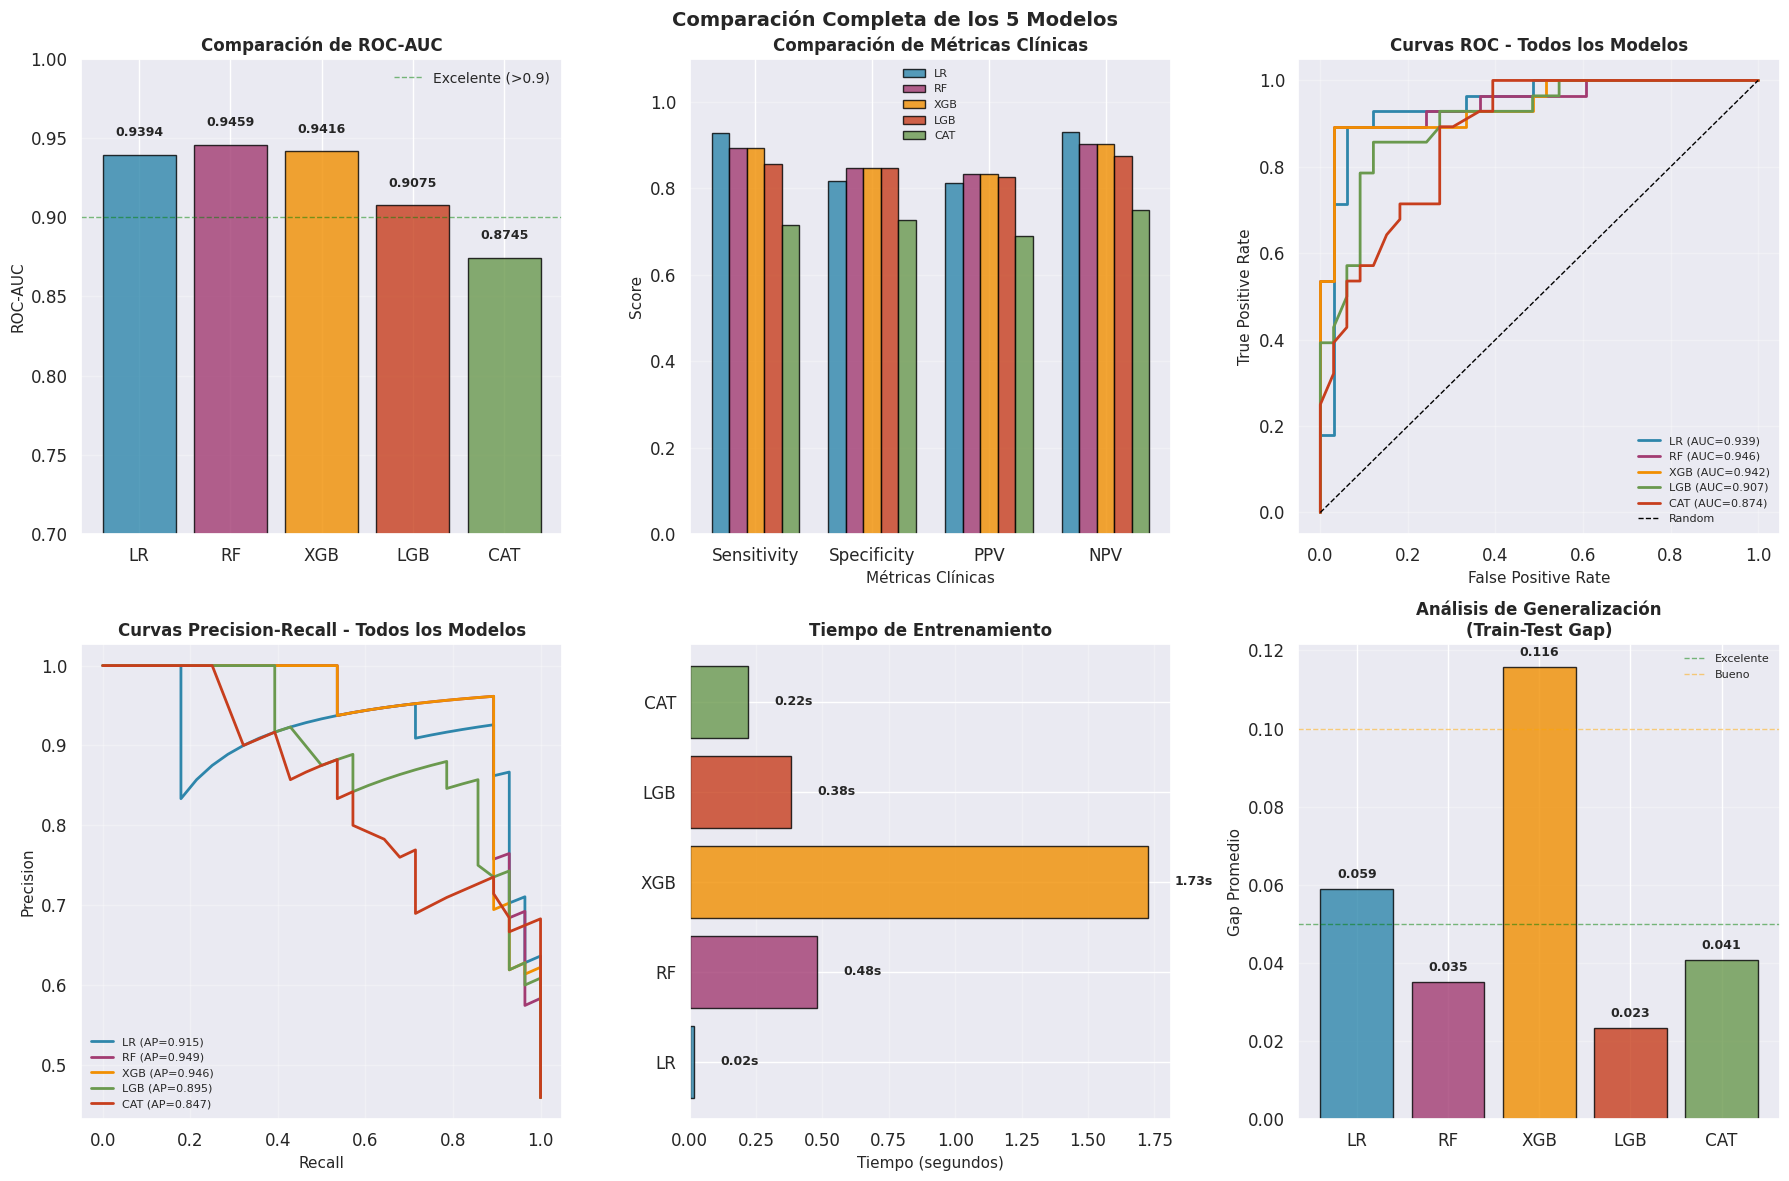

✓ Figura guardada: outputs/20_models_comparison.png

📊 ANÁLISIS ESTADÍSTICO DE DIFERENCIAS:

Diferencias con el mejor modelo (Random Forest):
--------------------------------------------------------------------------------
   • Logistic Regression      : +0.0065 (+0.69%) - ≈ Prácticamente igual
   • XGBoost ⭐                : +0.0043 (+0.46%) - ≈ Prácticamente igual
   • LightGBM 💡               : +0.0384 (+4.06%) - Diferencia moderada
   • CatBoost 🐱               : +0.0714 (+7.55%) - Diferencia significativa

RESUMEN EJECUTIVO DE LA COMPARACIÓN

🏆 MEJOR MODELO: Random Forest
   • ROC-AUC Test: 0.9459
   • Accuracy: 0.8689
   • Sensitivity: 0.8929
   • Specificity: 0.8485

📊 RANKING GENERAL (por ROC-AUC):

   🥇 Random Forest            : 0.9459
   🥈 XGBoost ⭐                : 0.9416
   🥉 Logistic Regression      : 0.9394
   4. LightGBM 💡               : 0.9075
   5. CatBoost 🐱               : 0.8745

⚡ MODELO MÁS RÁPIDO: Logistic Regression
   • Tiempo: 0.02s

🎯 MEJOR BALANCE (ROC-AUC

In [31]:
# ============================================================================
# 6.6 COMPARACIÓN DE MODELOS BASE
# ============================================================================

print("\n" + "="*80)
print("6.6 COMPARACIÓN DE MODELOS BASE")
print("="*80)

# ----------------------------------------------------------------------------
# 6.6.1 Tabla Comparativa Completa
# ----------------------------------------------------------------------------

print("\n📊 TABLA COMPARATIVA COMPLETA - TEST SET:")
print("="*80)

# Crear DataFrame con todas las métricas
comparison_all_models = pd.DataFrame({
    'Modelo': [
        'Logistic Regression',
        'Random Forest',
        'XGBoost ⭐',
        'LightGBM 💡',
        'CatBoost 🐱'
    ],
    'Accuracy': [
        test_accuracy_lr,
        test_accuracy_rf,
        test_accuracy_xgb,
        test_accuracy_lgb,
        test_accuracy_cat
    ],
    'Precision': [
        test_precision_lr,
        test_precision_rf,
        test_precision_xgb,
        test_precision_lgb,
        test_precision_cat
    ],
    'Recall': [
        test_recall_lr,
        test_recall_rf,
        test_recall_xgb,
        test_recall_lgb,
        test_recall_cat
    ],
    'F1-Score': [
        test_f1_lr,
        test_f1_rf,
        test_f1_xgb,
        test_f1_lgb,
        test_f1_cat
    ],
    'ROC-AUC': [
        test_roc_auc_lr,
        test_roc_auc_rf,
        test_roc_auc_xgb,
        test_roc_auc_lgb,
        test_roc_auc_cat
    ],
    'Sensitivity': [
        test_sensitivity_lr,
        test_sensitivity_rf,
        test_sensitivity_xgb,
        test_sensitivity_lgb,
        test_sensitivity_cat
    ],
    'Specificity': [
        test_specificity_lr,
        test_specificity_rf,
        test_specificity_xgb,
        test_specificity_lgb,
        test_specificity_cat
    ],
    'PPV': [
        test_ppv_lr,
        test_ppv_rf,
        test_ppv_xgb,
        test_ppv_lgb,
        test_ppv_cat
    ],
    'NPV': [
        test_npv_lr,
        test_npv_rf,
        test_npv_xgb,
        test_npv_lgb,
        test_npv_cat
    ],
    'Training Time (s)': [
        training_time,
        training_time_rf,
        training_time_xgb,
        training_time_lgb,
        training_time_cat
    ]
})

display(comparison_all_models.round(4))

# ----------------------------------------------------------------------------
# 6.6.2 Ranking por Métrica
# ----------------------------------------------------------------------------

print("\n🏆 RANKING DE MODELOS POR MÉTRICA:")
print("="*80)

metrics_to_rank = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
                   'Sensitivity', 'Specificity']

for metric in metrics_to_rank:
    ranking = comparison_all_models.sort_values(metric, ascending=False)
    print(f"\n📈 {metric}:")
    print("-"*80)
    for idx, (i, row) in enumerate(ranking.iterrows(), 1):
        medal = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else "  "
        print(f"   {medal} {idx}. {row['Modelo']:25s}: {row[metric]:.4f}")

# ----------------------------------------------------------------------------
# 6.6.3 Análisis de Overfitting (Train-Test Gap)
# ----------------------------------------------------------------------------

print("\n🔍 ANÁLISIS DE GENERALIZACIÓN (Train-Test Gap):")
print("="*80)

# Calcular gaps para cada modelo
gaps = {
    'Logistic Regression': np.mean([
        abs(train_accuracy_lr - test_accuracy_lr),
        abs(train_precision_lr - test_precision_lr),
        abs(train_recall_lr - test_recall_lr),
        abs(train_roc_auc_lr - test_roc_auc_lr)
    ]),
    'Random Forest': np.mean([
        abs(train_accuracy_rf - test_accuracy_rf),
        abs(train_precision_rf - test_precision_rf),
        abs(train_recall_rf - test_recall_rf),
        abs(train_roc_auc_rf - test_roc_auc_rf)
    ]),
    'XGBoost': np.mean([
        abs(train_accuracy_xgb - test_accuracy_xgb),
        abs(train_precision_xgb - test_precision_xgb),
        abs(train_recall_xgb - test_recall_xgb),
        abs(train_roc_auc_xgb - test_roc_auc_xgb)
    ]),
    'LightGBM': np.mean([
        abs(train_accuracy_lgb - test_accuracy_lgb),
        abs(train_precision_lgb - test_precision_lgb),
        abs(train_recall_lgb - test_recall_lgb),
        abs(train_roc_auc_lgb - test_roc_auc_lgb)
    ]),
    'CatBoost': np.mean([
        abs(train_accuracy_cat - test_accuracy_cat),
        abs(train_precision_cat - test_precision_cat),
        abs(train_recall_cat - test_recall_cat),
        abs(train_roc_auc_cat - test_roc_auc_cat)
    ])
}

gap_df = pd.DataFrame({
    'Modelo': list(gaps.keys()),
    'Gap Promedio': list(gaps.values()),
    'Evaluación': [
        '✅ Excelente' if v < 0.05 else
        '✅ Buena' if v < 0.10 else
        '⚠️  Revisar' if v < 0.15 else
        '❌ Overfitting'
        for v in gaps.values()
    ]
})

gap_df = gap_df.sort_values('Gap Promedio')
display(gap_df.round(4))

print("\n📊 Interpretación:")
print("-"*80)
print("   • Gap < 0.05:  Generalización EXCELENTE")
print("   • Gap < 0.10:  Generalización BUENA")
print("   • Gap < 0.15:  Ligero overfitting")
print("   • Gap ≥ 0.15:  Overfitting significativo")
# ----------------------------------------------------------------------------
# 6.6.4 Mejor Modelo Global
# ----------------------------------------------------------------------------

print("\n🏆 SELECCIÓN DEL MEJOR MODELO:")
print("="*80)

# Criterio principal: ROC-AUC
best_model_idx = comparison_all_models['ROC-AUC'].idxmax()
best_model_name = comparison_all_models.loc[best_model_idx, 'Modelo']
best_roc_auc = comparison_all_models.loc[best_model_idx, 'ROC-AUC']

print(f"\n🥇 MEJOR MODELO: {best_model_name}")
print("-"*80)
print(f"   • ROC-AUC:       {best_roc_auc:.4f}")
print(f"   • Accuracy:      {comparison_all_models.loc[best_model_idx, 'Accuracy']:.4f}")
print(f"   • Sensitivity:   {comparison_all_models.loc[best_model_idx, 'Sensitivity']:.4f}")
print(f"   • Specificity:   {comparison_all_models.loc[best_model_idx, 'Specificity']:.4f}")
print(f"   • F1-Score:      {comparison_all_models.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"   • Training Time: {comparison_all_models.loc[best_model_idx, 'Training Time (s)']:.2f}s")

# Top 3
print(f"\n🏅 TOP 3 MODELOS (por ROC-AUC):")
print("-"*80)
top3 = comparison_all_models.sort_values('ROC-AUC', ascending=False).head(3)
for idx, (i, row) in enumerate(top3.iterrows(), 1):
    medal = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉"
    print(f"   {medal} {row['Modelo']:25s}: ROC-AUC = {row['ROC-AUC']:.4f}")

# ----------------------------------------------------------------------------
# 6.6.5 Visualizaciones Comparativas
# ----------------------------------------------------------------------------

print("\n📊 Generando visualizaciones comparativas...")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Comparación de ROC-AUC
models_short = ['LR', 'RF', 'XGB', 'LGB', 'CAT']
roc_aucs = [test_roc_auc_lr, test_roc_auc_rf, test_roc_auc_xgb, test_roc_auc_lgb, test_roc_auc_cat]

bars = axes[0, 0].bar(models_short, roc_aucs, color=COLOR_PALETTE, alpha=0.8, edgecolor='black')
axes[0, 0].set_ylabel('ROC-AUC', fontsize=11)
axes[0, 0].set_title('Comparación de ROC-AUC', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim([0.7, 1.0])
axes[0, 0].grid(alpha=0.3, axis='y')
axes[0, 0].axhline(y=0.9, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Excelente (>0.9)')
axes[0, 0].legend()

# Agregar valores en las barras
for bar, val in zip(bars, roc_aucs):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Comparación de Métricas Clínicas
metrics_clinical = ['Sensitivity', 'Specificity', 'PPV', 'NPV']
x_pos = np.arange(len(metrics_clinical))
width = 0.15

for idx, (model_name, color) in enumerate(zip(['LR', 'RF', 'XGB', 'LGB', 'CAT'], COLOR_PALETTE)):
    values = [
        comparison_all_models.loc[idx, 'Sensitivity'],
        comparison_all_models.loc[idx, 'Specificity'],
        comparison_all_models.loc[idx, 'PPV'],
        comparison_all_models.loc[idx, 'NPV']
    ]
    axes[0, 1].bar(x_pos + idx*width, values, width, label=model_name,
                   color=color, alpha=0.8, edgecolor='black')

axes[0, 1].set_xlabel('Métricas Clínicas', fontsize=11)
axes[0, 1].set_ylabel('Score', fontsize=11)
axes[0, 1].set_title('Comparación de Métricas Clínicas', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos + width * 2)
axes[0, 1].set_xticklabels(metrics_clinical)
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(alpha=0.3, axis='y')
axes[0, 1].set_ylim([0, 1.1])

# 3. Curvas ROC de todos los modelos
axes[0, 2].plot(fpr_lr, tpr_lr, linewidth=2, label=f'LR (AUC={test_roc_auc_lr:.3f})',
                color=COLOR_PALETTE[0])
axes[0, 2].plot(fpr_rf, tpr_rf, linewidth=2, label=f'RF (AUC={test_roc_auc_rf:.3f})',
                color=COLOR_PALETTE[1])
axes[0, 2].plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGB (AUC={test_roc_auc_xgb:.3f})',
                color=COLOR_PALETTE[2])
axes[0, 2].plot(fpr_lgb, tpr_lgb, linewidth=2, label=f'LGB (AUC={test_roc_auc_lgb:.3f})',
                color=COLOR_PALETTE[4])
axes[0, 2].plot(fpr_cat, tpr_cat, linewidth=2, label=f'CAT (AUC={test_roc_auc_cat:.3f})',
                color=COLOR_PALETTE[3])
axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 2].set_xlabel('False Positive Rate', fontsize=11)
axes[0, 2].set_ylabel('True Positive Rate', fontsize=11)
axes[0, 2].set_title('Curvas ROC - Todos los Modelos', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(alpha=0.3)

# 4. Curvas Precision-Recall de todos los modelos
axes[1, 0].plot(recall_lr, precision_lr, linewidth=2, label=f'LR (AP={ap_lr:.3f})',
                color=COLOR_PALETTE[0])
axes[1, 0].plot(recall_rf, precision_rf, linewidth=2, label=f'RF (AP={ap_rf:.3f})',
                color=COLOR_PALETTE[1])
axes[1, 0].plot(recall_xgb, precision_xgb, linewidth=2, label=f'XGB (AP={ap_xgb:.3f})',
                color=COLOR_PALETTE[2])
axes[1, 0].plot(recall_lgb, precision_lgb, linewidth=2, label=f'LGB (AP={ap_lgb:.3f})',
                color=COLOR_PALETTE[4])
axes[1, 0].plot(recall_cat, precision_cat, linewidth=2, label=f'CAT (AP={ap_cat:.3f})',
                color=COLOR_PALETTE[3])
axes[1, 0].set_xlabel('Recall', fontsize=11)
axes[1, 0].set_ylabel('Precision', fontsize=11)
axes[1, 0].set_title('Curvas Precision-Recall - Todos los Modelos', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(alpha=0.3)

# 5. Training Time Comparison
training_times = [training_time, training_time_rf, training_time_xgb, training_time_lgb, training_time_cat]
bars_time = axes[1, 1].barh(models_short, training_times, color=COLOR_PALETTE, alpha=0.8, edgecolor='black')
axes[1, 1].set_xlabel('Tiempo (segundos)', fontsize=11)
axes[1, 1].set_title('Tiempo de Entrenamiento', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

for bar, val in zip(bars_time, training_times):
    width_bar = bar.get_width()
    axes[1, 1].text(width_bar + 0.1, bar.get_y() + bar.get_height()/2.,
                    f'{val:.2f}s', ha='left', va='center', fontsize=9, fontweight='bold')

# 6. Generalización (Train-Test Gap)
gap_values = list(gaps.values())
bars_gap = axes[1, 2].bar(models_short, gap_values, color=COLOR_PALETTE, alpha=0.8, edgecolor='black')
axes[1, 2].set_ylabel('Gap Promedio', fontsize=11)
axes[1, 2].set_title('Análisis de Generalización\n(Train-Test Gap)', fontsize=12, fontweight='bold')
axes[1, 2].axhline(y=0.05, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Excelente')
axes[1, 2].axhline(y=0.10, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Bueno')
axes[1, 2].legend(fontsize=8)
axes[1, 2].grid(alpha=0.3, axis='y')

for bar, val in zip(bars_gap, gap_values):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.002,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Comparación Completa de los 5 Modelos', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/20_models_comparison.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/20_models_comparison.png")

# ----------------------------------------------------------------------------
# 6.6.6 Análisis Estadístico de Diferencias
# ----------------------------------------------------------------------------

print("\n📊 ANÁLISIS ESTADÍSTICO DE DIFERENCIAS:")
print("="*80)

# Diferencias entre mejor modelo y los demás (en ROC-AUC)
print(f"\nDiferencias con el mejor modelo ({best_model_name}):")
print("-"*80)

for idx, row in comparison_all_models.iterrows():
    if row['Modelo'] != best_model_name:
        diff = best_roc_auc - row['ROC-AUC']
        pct_diff = (diff / best_roc_auc) * 100

        if abs(diff) < 0.01:
            status = "≈ Prácticamente igual"
        elif abs(diff) < 0.03:
            status = "Diferencia pequeña"
        elif abs(diff) < 0.05:
            status = "Diferencia moderada"
        else:
            status = "Diferencia significativa"

        print(f"   • {row['Modelo']:25s}: {diff:+.4f} ({pct_diff:+.2f}%) - {status}")

# ----------------------------------------------------------------------------
# 6.6.7 Resumen Ejecutivo
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("RESUMEN EJECUTIVO DE LA COMPARACIÓN")
print("="*80)

print(f"""
🏆 MEJOR MODELO: {best_model_name}
   • ROC-AUC Test: {best_roc_auc:.4f}
   • Accuracy: {comparison_all_models.loc[best_model_idx, 'Accuracy']:.4f}
   • Sensitivity: {comparison_all_models.loc[best_model_idx, 'Sensitivity']:.4f}
   • Specificity: {comparison_all_models.loc[best_model_idx, 'Specificity']:.4f}

📊 RANKING GENERAL (por ROC-AUC):
""")

for idx, (i, row) in enumerate(comparison_all_models.sort_values('ROC-AUC', ascending=False).iterrows(), 1):
    medal = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else f"{idx}."
    print(f"   {medal} {row['Modelo']:25s}: {row['ROC-AUC']:.4f}")

print(f"""
⚡ MODELO MÁS RÁPIDO: {comparison_all_models.loc[comparison_all_models['Training Time (s)'].idxmin(), 'Modelo']}
   • Tiempo: {comparison_all_models['Training Time (s)'].min():.2f}s

🎯 MEJOR BALANCE (ROC-AUC + Generalización):
   • Revisar modelos con Gap < 0.05 y ROC-AUC > 0.85
""")

print("="*80)

# Guardar comparación en CSV
comparison_all_models.to_csv(f'{OUTPUT_DIR}/models_comparison_summary.csv', index=False)
print(f"\n✓ Tabla de comparación guardada: {OUTPUT_DIR}/models_comparison_summary.csv")

<a id='67-visualizaciones'></a>
## 6.7 Visualizaciones Consolidadas

Se generan visualizaciones de alta calidad que comparan las curvas ROC y Precision-Recall de todos los modelos, así como la importancia de features entre los modelos tree-based.


6.7 VISUALIZACIONES CONSOLIDADAS

📊 Generando curva ROC consolidada...
--------------------------------------------------------------------------------


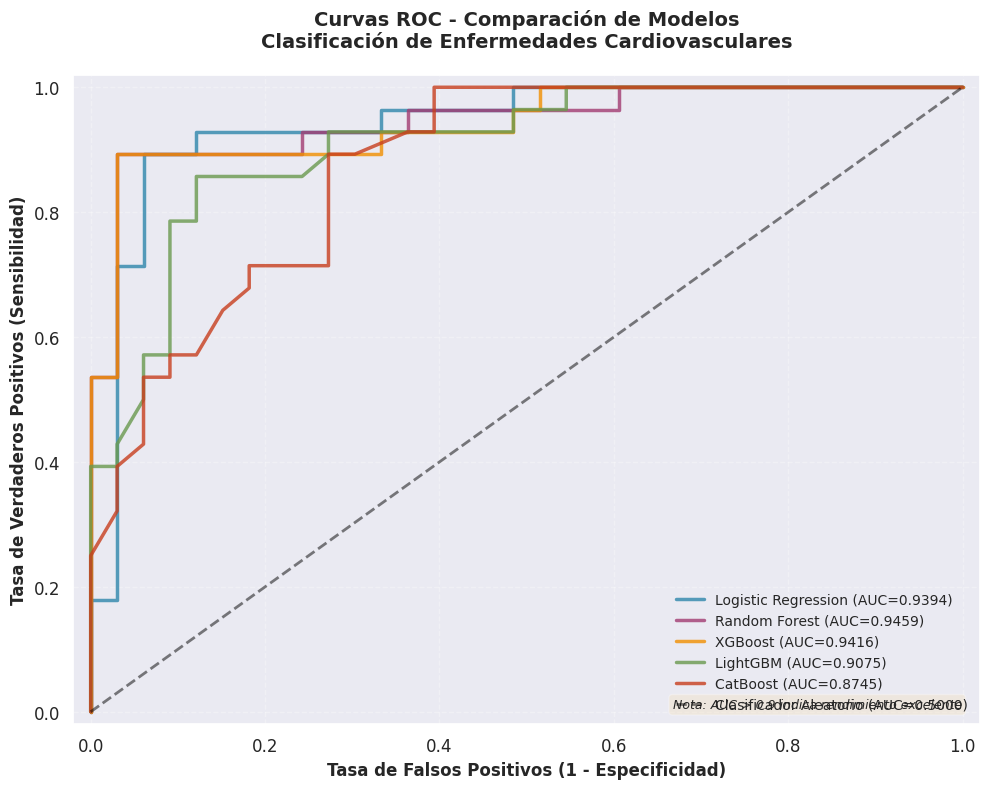

✓ Figura guardada: outputs/21_roc_curves_all_models.png

📊 Generando curvas Precision-Recall consolidadas...
--------------------------------------------------------------------------------


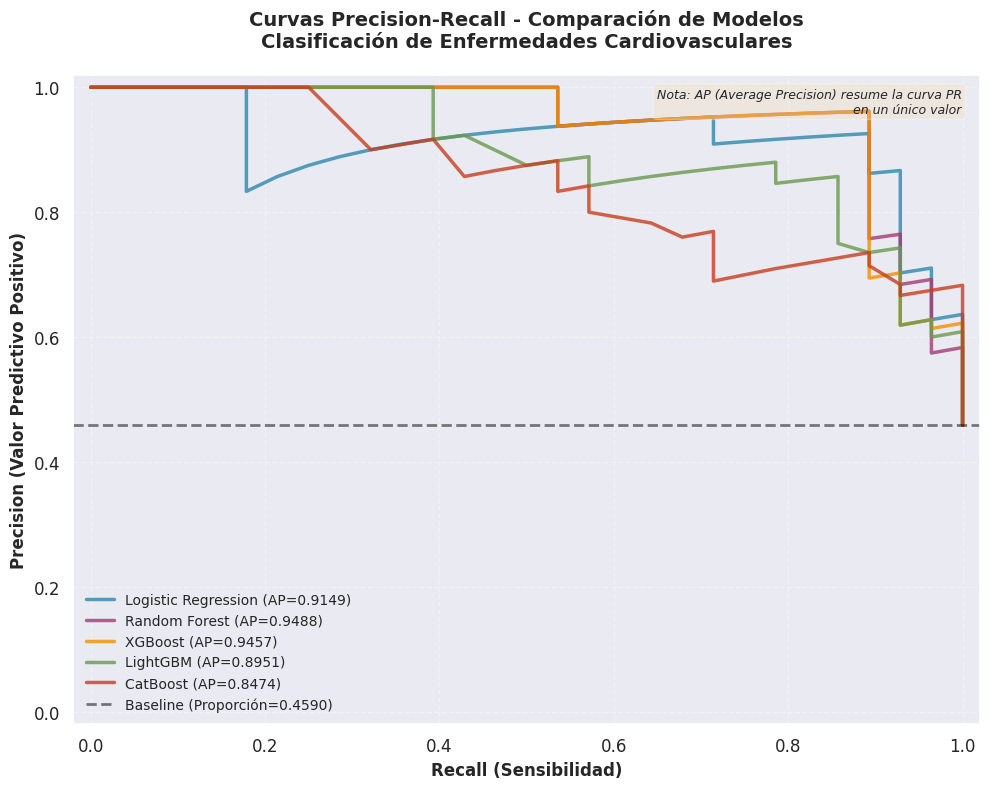

✓ Figura guardada: outputs/22_pr_curves_all_models.png

📊 Generando comparación de Feature Importance...
--------------------------------------------------------------------------------
🔍 Verificando columnas de DataFrames...
✓ Columnas verificadas
✓ 9 features únicas identificadas
✓ Random Forest integrado
✓ XGBoost integrado
✓ LightGBM integrado
✓ CatBoost integrado
✓ DataFrame consolidado creado: (9, 6)


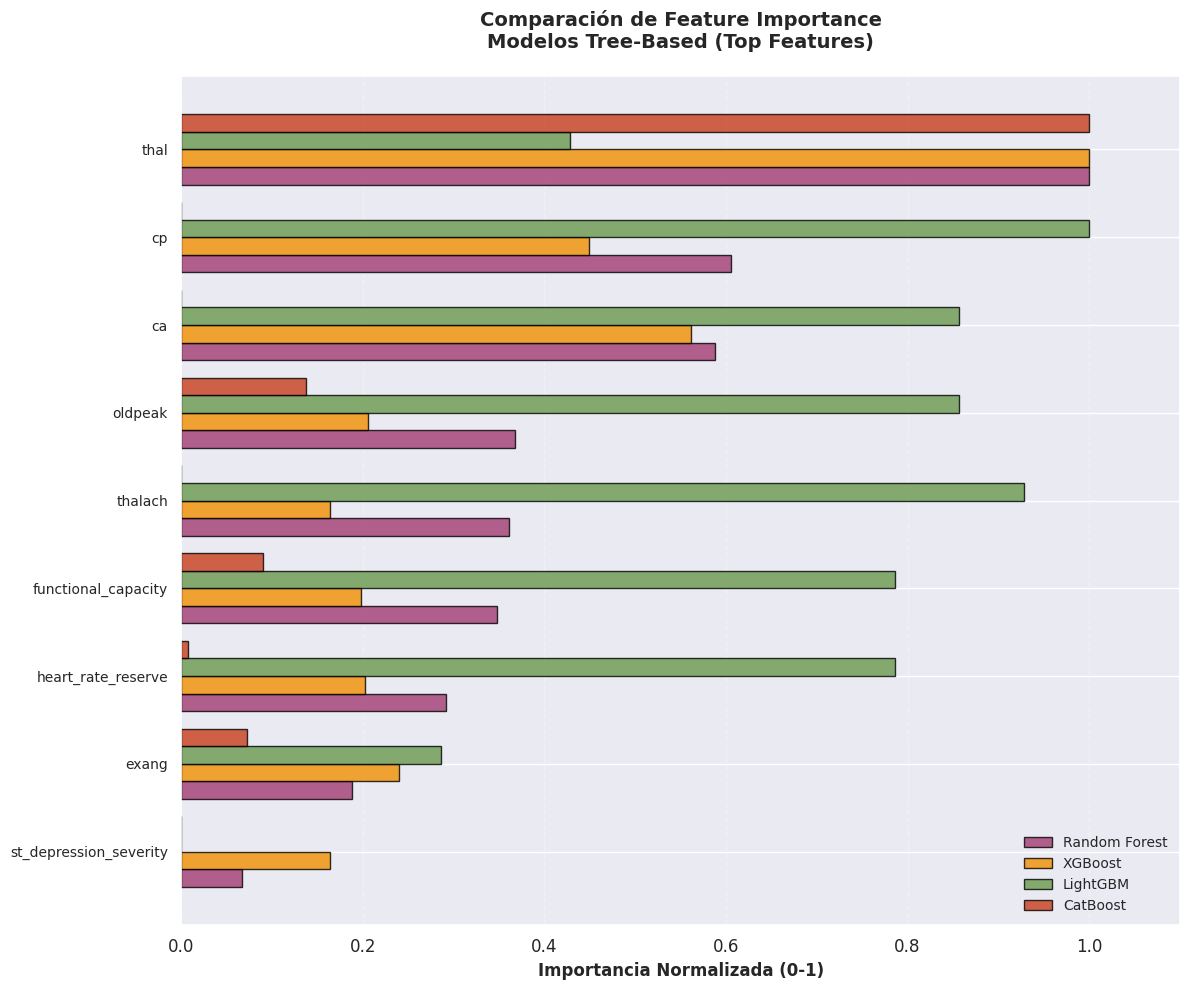

✓ Figura guardada: outputs/23_feature_importance_comparison.png
✓ Tabla guardada: outputs/feature_importance_comparison.csv

🌟 TOP 5 FEATURES MÁS CONSISTENTES (Promedio entre modelos):

thal:
   • Importancia Promedio: 0.8571
   • Random Forest:  1.0000
   • XGBoost:        1.0000
   • LightGBM:       0.4286
   • CatBoost:       1.0000

cp:
   • Importancia Promedio: 0.5135
   • Random Forest:  0.6052
   • XGBoost:        0.4489
   • LightGBM:       1.0000
   • CatBoost:       0.0000

ca:
   • Importancia Promedio: 0.5017
   • Random Forest:  0.5883
   • XGBoost:        0.5614
   • LightGBM:       0.8571
   • CatBoost:       0.0000

oldpeak:
   • Importancia Promedio: 0.3919
   • Random Forest:  0.3681
   • XGBoost:        0.2053
   • LightGBM:       0.8571
   • CatBoost:       0.1370

thalach:
   • Importancia Promedio: 0.3632
   • Random Forest:  0.3607
   • XGBoost:        0.1635
   • LightGBM:       0.9286
   • CatBoost:       0.0000

📊 Generando heatmap de importancia de features.

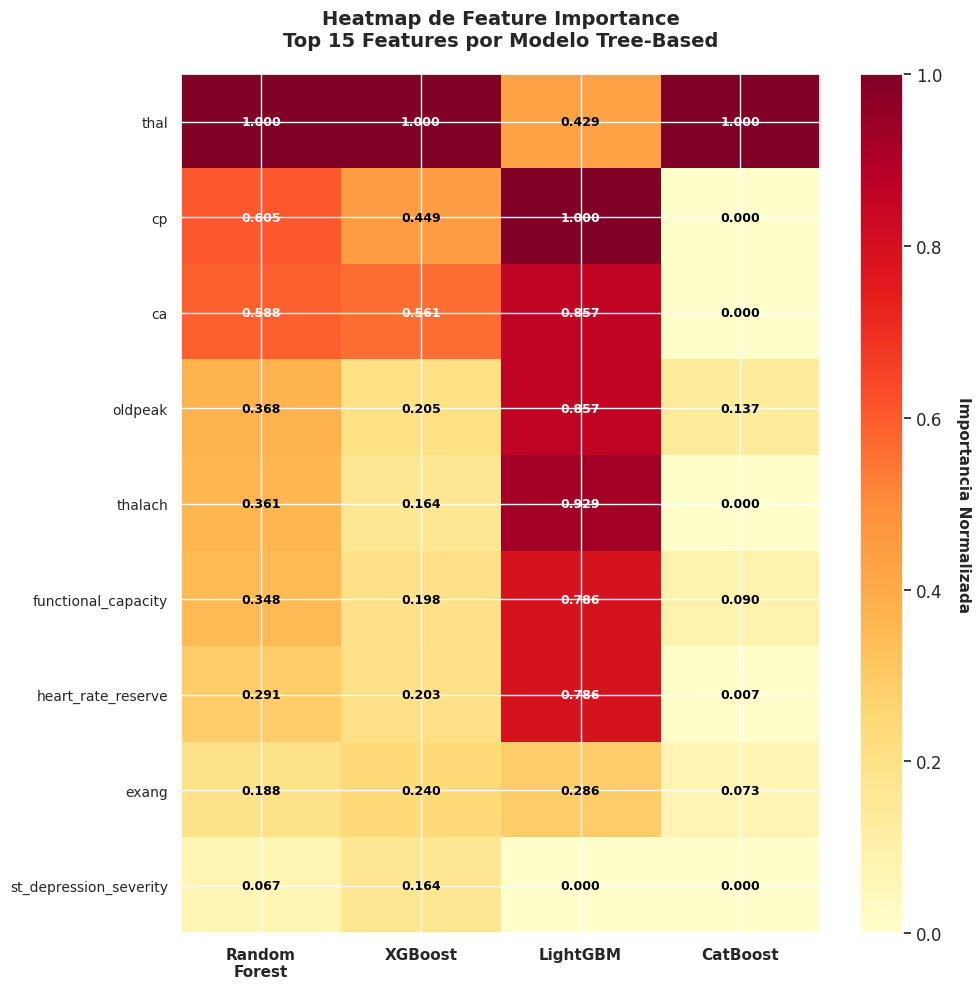

✓ Figura guardada: outputs/24_feature_importance_heatmap.png

RESUMEN: VISUALIZACIONES CONSOLIDADAS

✅ Visualizaciones generadas:
   • 21_roc_curves_all_models.png          - Curvas ROC
   • 22_pr_curves_all_models.png           - Curvas Precision-Recall
   • 23_feature_importance_comparison.png  - Comparación de importancia (barras)
   • 24_feature_importance_heatmap.png     - Heatmap de importancia

📊 Archivos CSV generados:
   • feature_importance_comparison.csv     - Tabla de importancias

🌟 Top 5 Features Más Importantes (Promedio):

   • thal                     : 0.8571
   • cp                       : 0.5135
   • ca                       : 0.5017
   • oldpeak                  : 0.3919
   • thalach                  : 0.3632


In [32]:
# ============================================================================
# 6.7 VISUALIZACIONES CONSOLIDADAS
# ============================================================================

print("\n" + "="*80)
print("6.7 VISUALIZACIONES CONSOLIDADAS")
print("="*80)

# ----------------------------------------------------------------------------
# 6.7.1 Curvas ROC - Todos los Modelos (Alta Calidad)
# ----------------------------------------------------------------------------

print("\n📊 Generando curva ROC consolidada...")
print("-"*80)

fig, ax = plt.subplots(figsize=(10, 8))

# Plotear todas las curvas ROC
ax.plot(fpr_lr, tpr_lr, linewidth=2.5, label=f'Logistic Regression (AUC={test_roc_auc_lr:.4f})',
        color=COLOR_PALETTE[0], alpha=0.8)
ax.plot(fpr_rf, tpr_rf, linewidth=2.5, label=f'Random Forest (AUC={test_roc_auc_rf:.4f})',
        color=COLOR_PALETTE[1], alpha=0.8)
ax.plot(fpr_xgb, tpr_xgb, linewidth=2.5, label=f'XGBoost (AUC={test_roc_auc_xgb:.4f})',
        color=COLOR_PALETTE[2], alpha=0.8)
ax.plot(fpr_lgb, tpr_lgb, linewidth=2.5, label=f'LightGBM (AUC={test_roc_auc_lgb:.4f})',
        color=COLOR_PALETTE[4], alpha=0.8)
ax.plot(fpr_cat, tpr_cat, linewidth=2.5, label=f'CatBoost (AUC={test_roc_auc_cat:.4f})',
        color=COLOR_PALETTE[3], alpha=0.8)

# Línea diagonal (clasificador aleatorio)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Clasificador Aleatorio (AUC=0.5000)', alpha=0.5)

# Personalización
ax.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12, fontweight='bold')
ax.set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12, fontweight='bold')
ax.set_title('Curvas ROC - Comparación de Modelos\nClasificación de Enfermedades Cardiovasculares',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10, framealpha=0.95)
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

# Añadir nota
ax.text(0.98, 0.02, 'Nota: AUC > 0.9 indica rendimiento excelente',
        transform=ax.transAxes, fontsize=9, style='italic',
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/21_roc_curves_all_models.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/21_roc_curves_all_models.png")

# ----------------------------------------------------------------------------
# 6.7.2 Curvas Precision-Recall - Todos los Modelos (Alta Calidad)
# ----------------------------------------------------------------------------

print("\n📊 Generando curvas Precision-Recall consolidadas...")
print("-"*80)

fig, ax = plt.subplots(figsize=(10, 8))

# Plotear todas las curvas PR
ax.plot(recall_lr, precision_lr, linewidth=2.5, label=f'Logistic Regression (AP={ap_lr:.4f})',
        color=COLOR_PALETTE[0], alpha=0.8)
ax.plot(recall_rf, precision_rf, linewidth=2.5, label=f'Random Forest (AP={ap_rf:.4f})',
        color=COLOR_PALETTE[1], alpha=0.8)
ax.plot(recall_xgb, precision_xgb, linewidth=2.5, label=f'XGBoost (AP={ap_xgb:.4f})',
        color=COLOR_PALETTE[2], alpha=0.8)
ax.plot(recall_lgb, precision_lgb, linewidth=2.5, label=f'LightGBM (AP={ap_lgb:.4f})',
        color=COLOR_PALETTE[4], alpha=0.8)
ax.plot(recall_cat, precision_cat, linewidth=2.5, label=f'CatBoost (AP={ap_cat:.4f})',
        color=COLOR_PALETTE[3], alpha=0.8)

# Línea base (proporción de clase positiva)
baseline = (y_test == 1).sum() / len(y_test)
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=2,
           label=f'Baseline (Proporción={baseline:.4f})', alpha=0.5)

# Personalización
ax.set_xlabel('Recall (Sensibilidad)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision (Valor Predictivo Positivo)', fontsize=12, fontweight='bold')
ax.set_title('Curvas Precision-Recall - Comparación de Modelos\nClasificación de Enfermedades Cardiovasculares',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower left', fontsize=10, framealpha=0.95)
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

# Añadir nota
ax.text(0.98, 0.98, 'Nota: AP (Average Precision) resume la curva PR\nen un único valor',
        transform=ax.transAxes, fontsize=9, style='italic',
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/22_pr_curves_all_models.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/22_pr_curves_all_models.png")

# ----------------------------------------------------------------------------
# 6.7.3 Feature Importance Comparison (Modelos Tree-based) - CORREGIDO
# ----------------------------------------------------------------------------

print("\n📊 Generando comparación de Feature Importance...")
print("-"*80)

# Consolidar top 10 features de cada modelo tree-based
top_n = 10

# CORRECCIÓN: Verificar nombres de columnas en cada DataFrame
print("🔍 Verificando columnas de DataFrames...")

# Random Forest
if 'Importance' in feature_importance_rf.columns:
    rf_imp_col = 'Importance'
elif 'Importance_Gain' in feature_importance_rf.columns:
    rf_imp_col = 'Importance_Gain'
else:
    print(f"   RF columnas: {feature_importance_rf.columns.tolist()}")
    rf_imp_col = feature_importance_rf.columns[1]  # Tomar segunda columna

# XGBoost
if 'Importance' in feature_importance_gain.columns:
    xgb_imp_col = 'Importance'
elif 'Importance_Gain' in feature_importance_gain.columns:
    xgb_imp_col = 'Importance_Gain'
else:
    print(f"   XGB columnas: {feature_importance_gain.columns.tolist()}")
    xgb_imp_col = feature_importance_gain.columns[1]

# LightGBM
if 'Importance' in feature_importance_lgb.columns:
    lgb_imp_col = 'Importance'
else:
    print(f"   LGB columnas: {feature_importance_lgb.columns.tolist()}")
    lgb_imp_col = feature_importance_lgb.columns[1]

# CatBoost
if 'Importance' in feature_importance_cat.columns:
    cat_imp_col = 'Importance'
else:
    print(f"   CAT columnas: {feature_importance_cat.columns.tolist()}")
    cat_imp_col = feature_importance_cat.columns[1]

print("✓ Columnas verificadas")

# Obtener top features de cada modelo
top_rf = set(feature_importance_rf.head(top_n)['Feature'].tolist())
top_xgb = set(feature_importance_gain.head(top_n)['Feature'].tolist())
top_lgb = set(feature_importance_lgb.head(top_n)['Feature'].tolist())
top_cat = set(feature_importance_cat.head(top_n)['Feature'].tolist())

# Union de todas las features importantes
important_features = list(top_rf | top_xgb | top_lgb | top_cat)
important_features.sort()

print(f"✓ {len(important_features)} features únicas identificadas")

# Crear DataFrame consolidado
importance_consolidated = pd.DataFrame({
    'Feature': important_features
})

# Añadir importancias de cada modelo (normalizar a 0-1)
model_configs = [
    ('Random Forest', feature_importance_rf, rf_imp_col, 'RF'),
    ('XGBoost', feature_importance_gain, xgb_imp_col, 'XGB'),
    ('LightGBM', feature_importance_lgb, lgb_imp_col, 'LGB'),
    ('CatBoost', feature_importance_cat, cat_imp_col, 'CAT')
]

for model_name, df_imp, imp_col, col_name in model_configs:
    # Crear copia con columnas renombradas
    temp_df = df_imp[['Feature', imp_col]].copy()
    temp_df.columns = ['Feature', col_name]

    # Normalizar importancia a 0-1
    max_imp = temp_df[col_name].max()
    if max_imp > 0:
        temp_df[col_name] = temp_df[col_name] / max_imp

    # Merge
    importance_consolidated = importance_consolidated.merge(temp_df, on='Feature', how='left')
    print(f"✓ {model_name} integrado")

# Llenar NaN con 0
importance_consolidated.fillna(0, inplace=True)

# Calcular promedio de importancia
importance_consolidated['Avg_Importance'] = importance_consolidated[['RF', 'XGB', 'LGB', 'CAT']].mean(axis=1)

# Ordenar por importancia promedio
importance_consolidated = importance_consolidated.sort_values('Avg_Importance', ascending=True)

print(f"✓ DataFrame consolidado creado: {importance_consolidated.shape}")

# Visualización (EL RESTO DEL CÓDIGO CONTINÚA IGUAL...)
fig, ax = plt.subplots(figsize=(12, 10))

y_pos = np.arange(len(importance_consolidated))
width = 0.2

ax.barh(y_pos - 1.5*width, importance_consolidated['RF'], width,
        label='Random Forest', color=COLOR_PALETTE[1], alpha=0.8, edgecolor='black')
ax.barh(y_pos - 0.5*width, importance_consolidated['XGB'], width,
        label='XGBoost', color=COLOR_PALETTE[2], alpha=0.8, edgecolor='black')
ax.barh(y_pos + 0.5*width, importance_consolidated['LGB'], width,
        label='LightGBM', color=COLOR_PALETTE[4], alpha=0.8, edgecolor='black')
ax.barh(y_pos + 1.5*width, importance_consolidated['CAT'], width,
        label='CatBoost', color=COLOR_PALETTE[3], alpha=0.8, edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(importance_consolidated['Feature'], fontsize=10)
ax.set_xlabel('Importancia Normalizada (0-1)', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Feature Importance\nModelos Tree-Based (Top Features)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10, framealpha=0.95)
ax.grid(alpha=0.3, axis='x', linestyle='--')
ax.set_xlim([0, 1.1])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/23_feature_importance_comparison.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/23_feature_importance_comparison.png")

# Guardar tabla de importancias
importance_consolidated_export = importance_consolidated.sort_values('Avg_Importance', ascending=False)
importance_consolidated_export.to_csv(f'{OUTPUT_DIR}/feature_importance_comparison.csv', index=False)
print(f"✓ Tabla guardada: {OUTPUT_DIR}/feature_importance_comparison.csv")

# ----------------------------------------------------------------------------
# 6.7.4 Top 5 Features más Consistentes
# ----------------------------------------------------------------------------

print("\n🌟 TOP 5 FEATURES MÁS CONSISTENTES (Promedio entre modelos):")
print("="*80)

top_5_features = importance_consolidated_export.head(5)

for idx, row in top_5_features.iterrows():
    print(f"\n{row['Feature']}:")
    print(f"   • Importancia Promedio: {row['Avg_Importance']:.4f}")
    print(f"   • Random Forest:  {row['RF']:.4f}")
    print(f"   • XGBoost:        {row['XGB']:.4f}")
    print(f"   • LightGBM:       {row['LGB']:.4f}")
    print(f"   • CatBoost:       {row['CAT']:.4f}")

# ----------------------------------------------------------------------------
# 6.7.5 Heatmap de Importancia
# ----------------------------------------------------------------------------

print("\n📊 Generando heatmap de importancia de features...")
print("-"*80)

# Seleccionar top 15 features por importancia promedio
top_15_features = importance_consolidated_export.head(15)

# Preparar datos para heatmap
heatmap_data = top_15_features[['RF', 'XGB', 'LGB', 'CAT']].values
feature_names = top_15_features['Feature'].tolist()

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

# Configurar ejes
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(len(feature_names)))
ax.set_xticklabels(['Random\nForest', 'XGBoost', 'LightGBM', 'CatBoost'], fontsize=11, fontweight='bold')
ax.set_yticklabels(feature_names, fontsize=10)

# Añadir valores en las celdas
for i in range(len(feature_names)):
    for j in range(4):
        text = ax.text(j, i, f'{heatmap_data[i, j]:.3f}',
                      ha="center", va="center", color="black" if heatmap_data[i, j] < 0.5 else "white",
                      fontsize=9, fontweight='bold')

ax.set_title('Heatmap de Feature Importance\nTop 15 Features por Modelo Tree-Based',
             fontsize=14, fontweight='bold', pad=20)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Importancia Normalizada', rotation=270, labelpad=20, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/24_feature_importance_heatmap.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/24_feature_importance_heatmap.png")

# ----------------------------------------------------------------------------
# 6.7.6 Resumen de Visualizaciones
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("RESUMEN: VISUALIZACIONES CONSOLIDADAS")
print("="*80)

print(f"""
✅ Visualizaciones generadas:
   • 21_roc_curves_all_models.png          - Curvas ROC
   • 22_pr_curves_all_models.png           - Curvas Precision-Recall
   • 23_feature_importance_comparison.png  - Comparación de importancia (barras)
   • 24_feature_importance_heatmap.png     - Heatmap de importancia

📊 Archivos CSV generados:
   • feature_importance_comparison.csv     - Tabla de importancias

🌟 Top 5 Features Más Importantes (Promedio):
""")

for idx, row in top_5_features.iterrows():
    print(f"   • {row['Feature']:25s}: {row['Avg_Importance']:.4f}")

print("="*80)